# World Data League 2022

## 🎯 Challenge
Predicting a safety score for women in Costa Rica



## 👥 Authors
* Akshay Punjabi
* Pablo Izquierdo Ayala


## 💻 Development

### Data Loading

#### Getting the data

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
!wget "https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip"

--2022-05-24 08:09:37--  https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip
Resolving wdl-data.fra1.digitaloceanspaces.com (wdl-data.fra1.digitaloceanspaces.com)... 5.101.109.44
Connecting to wdl-data.fra1.digitaloceanspaces.com (wdl-data.fra1.digitaloceanspaces.com)|5.101.109.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40578044 (39M) [application/zip]
Saving to: ‘urbanalytica_datasets.zip’

urbanalytica_datase 100%[===================>]  38.70M  13.8MB/s    in 2.8s    

2022-05-24 08:09:40 (13.8 MB/s) - ‘urbanalytica_datasets.zip’ saved [40578044/40578044]



In [ ]:
!unzip "urbanalytica_datasets.zip"

Archive:  urbanalytica_datasets.zip
  inflating: datasets/costa_rica_street_harassement_english.csv  
  inflating: datasets/district_data.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_catasto_central.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_security.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_commercial_centers.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_entertainment_culture.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_communal_areas.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_patrimonio.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_governmental.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_churches.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_catasto_vias.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_education.csv  
  inflating: datasets/arcGIS_zoning_data_san_jose/arcGIS_catasto_codominios.csv  
  infla

#### Imports

In [ ]:
!pip install catboost shap kaleido eli5 geopandas osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import math

import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd 
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import CatBoost, Pool
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
import shap

import seaborn as sns

import geopandas as gpd

import ast

from shapely import wkt
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from descartes import PolygonPatch


weight_by_length = False

#ox.__version__

from itertools import cycle

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.8.0


#### Loading DataFrame

In [ ]:
%%time
print(f"{'*'*10} Loading Data... {'*'*10}")
df = pd.read_csv("/content/datasets/costa_rica_crime_data_english/costa_rica_crimes_english.csv")

********** Loading Data... **********
CPU times: user 1.1 s, sys: 96.2 ms, total: 1.2 s
Wall time: 1.2 s


In [ ]:
df['Date'] = pd.to_datetime(df['Date'] + df['Time'].str[:8], format='%d.%m.%y%H:%M:%S')
df['ID'] = np.arange(len(df))
df.index = pd.DatetimeIndex(df.Date)

### Understanding the Data (EDA)

Let's check the data!

In [ ]:
df.head()

Unnamed: 0    Crime SubtypeCrime                Date  \
Date                                                                        
2022-01-08 06:00:00           0  ASSAULT  COLD WEAPON 2022-01-08 06:00:00   
2022-01-12 12:00:00           1  ASSAULT  COLD WEAPON 2022-01-12 12:00:00   
2022-01-13 18:00:00           2  ASSAULT  COLD WEAPON 2022-01-13 18:00:00   
2022-01-15 03:00:00           3  ASSAULT  COLD WEAPON 2022-01-15 03:00:00   
2022-01-13 15:00:00           4  ASSAULT  COLD WEAPON 2022-01-13 15:00:00   

                                    Time  \
Date                                       
2022-01-08 06:00:00  06:00:00 - 08:59:59   
2022-01-12 12:00:00  12:00:00 - 14:59:59   
2022-01-13 18:00:00  18:00:00 - 20:59:59   
2022-01-15 03:00:00  03:00:00 - 05:59:59   
2022-01-13 15:00:00  15:00:00 - 17:59:59   

                                                         SubtypeVictim  \
Date                                                                     
2022-01-08 06:00:00                            LOTTERY SELLER [PERSON]   
2022-01-12 12:00:00  PUBLIC SERVICE/LEGAL OR ILLEGAL TAXI/BUS [VEHI...   
2022-01-13 18:00:00                                PEDESTRIAN [PERSON]   
2022-01-15 03:00:00                                PEDESTRIAN [PERSON]   
2022-01-13 15:00:00                                PEDESTRIAN [PERSON]   

                         Age   Gender  Nationality    Province      Canton  \
Date                                                                         
2022-01-08 06:00:00  >18 y/o   female   COSTA RICA    SAN JOSE    SAN JOSE   
2022-01-12 12:00:00  unknown  unknown  Desconocido  PUNTARENAS  PUNTARENAS   
2022-01-13 18:00:00  >18 y/o   female   COSTA RICA    SAN JOSE      ASERRI   
2022-01-15 03:00:00  >18 y/o     male    NICARAGUA    SAN JOSE      ASERRI   
2022-01-13 15:00:00  >18 y/o   female   COSTA RICA    SAN JOSE    SAN JOSE   

                      District  ID  
Date                                
2022-01-08 06:00:00   HOSPITAL   0  
2022-01-12 12:00:00  CHACARITA   1  
2022-01-13 18:00:00     ASERRI   2  
2022-01-15 03:00:00     ASERRI   3  
2022-01-13 15:00:00   HOSPITAL   4

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 648226 entries, 2022-01-08 06:00:00 to 2010-12-30 00:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Unnamed: 0     648226 non-null  int64         
 1   Crime          648226 non-null  object        
 2   SubtypeCrime   648226 non-null  object        
 3   Date           648226 non-null  datetime64[ns]
 4   Time           648226 non-null  object        
 5   SubtypeVictim  648226 non-null  object        
 6   Age            648226 non-null  object        
 7   Gender         648226 non-null  object        
 8   Nationality    648226 non-null  object        
 9   Province       648226 non-null  object        
 10  Canton         648226 non-null  object        
 11  District       648226 non-null  object        
 12  ID             648226 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 69.2+ MB


First we need to make the decision of whether we want to tackle Costa Rica as a whole or just the San José canton. Let's look at the amount of crimes.

SAN JOSE       0.364880
ALAJUELA       0.158948
PUNTARENAS     0.126117
LIMON          0.097975
HEREDIA        0.090564
GUANACASTE     0.084569
CARTAGO        0.076939
DESCONOCIDO    0.000008
Name: Province, dtype: float64


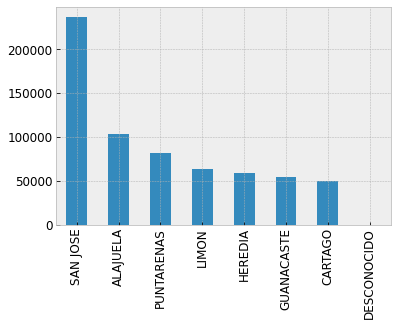

In [ ]:
print(df['Province'].value_counts(normalize = True))
df['Province'].value_counts().plot.bar()

As we can see, more then 36% of the registered crimes are commited within the San José Province. Just from this measure it already makes sense to tackle San José as an independent case. Let's now check it based on the cantons within Costa Rica.

SAN JOSE      0.160881
ALAJUELA      0.058409
HEREDIA       0.038431
PUNTARENAS    0.034223
SAN CARLOS    0.032226
                ...   
ZARCERO       0.000847
DOTA          0.000833
TURRUBARES    0.000742
HOJANCHA      0.000734
RIO CUARTO    0.000523
Name: Canton, Length: 83, dtype: float64


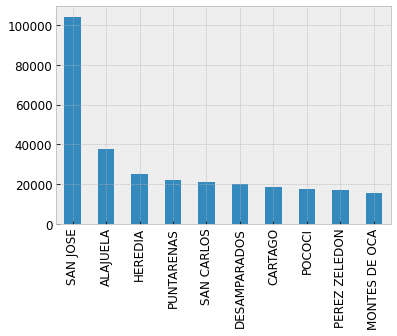

In [ ]:
print(df["Canton"].value_counts(normalize = True))
df["Canton"].value_counts()[:10].plot.bar()

We already see that the canton of San José (In the province of San José) has by far the highest amount of crimes (16% of total Costa Rica). With this in mind, we consider that tackling this canton individually makes more sense, as we can create a targeted solution that can have a bigger impact. 

##### Canton - San José - Crimes

In [ ]:
df = df[df["Canton"] == "SAN JOSE"]

Now let's see the types of crimes that are commited in San José.

ASSAULT              0.430802
THEFT                0.351559
ROBBERY              0.082829
VEHICLE VANDALISM    0.078763
VEHICLE THEFT        0.050188
HOMICIDE             0.005859
Name: Crime, dtype: float64


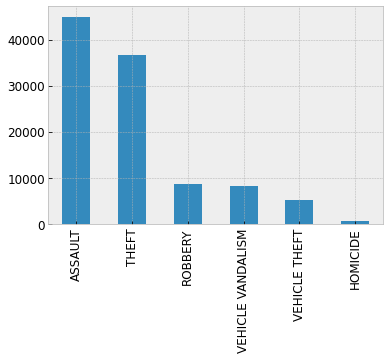

In [ ]:
print(df["Crime"].value_counts(normalize = True))
df["Crime"].value_counts().plot.bar()

Most of the reported crimes are either assaults or thefts (making up to a total of 78% combined). Let's check how this distribution looks like if we divide the information by gender.

In [ ]:
df.groupby("Gender")["Crime"].count()

Gender
female     37405
male       64249
unknown     2633
Name: Crime, dtype: int64

We see that there 

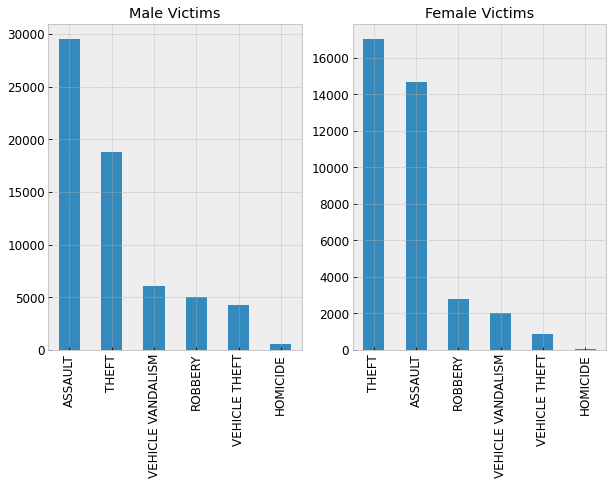

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (10,6))
df[df["Gender"] == "male"]["Crime"].value_counts().plot.bar(ax = axes[0], title = "Male Victims")
df[df["Gender"] == "female"]["Crime"].value_counts().plot.bar(ax = axes[1], title = "Female Victims")


Here we obtain some interesting information. Both males and females are victims are victims of thefts and assaults. However, female victims seem to suffer more thefts than assaults by a close margin, whereas male victims seem to suffer more assaults than thefts by a significant margin. 

This could be due to many reasons. Our straight forward thought is that women could be less combative when approached by a criminal, they could potentially carry objects that are easier to become targets of a theft (such as purses or bags), or men and women report crimes with different frequencies.

Let's now check the top 5 subtype crimes for assaults and thefts within these two gender groups.


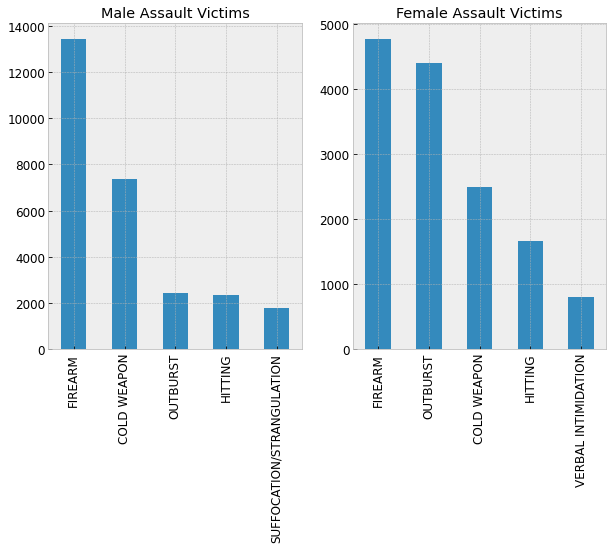

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (10,6))
df[(df["Gender"] == "male") & (df["Crime"] == "ASSAULT")]["SubtypeCrime"].value_counts()[:5].plot.bar(ax = axes[0], title = "Male Assault Victims")
df[(df["Gender"] == "female") & (df["Crime"] == "ASSAULT")]["SubtypeCrime"].value_counts()[:5].plot.bar(ax = axes[1], title = "Female Assault Victims")


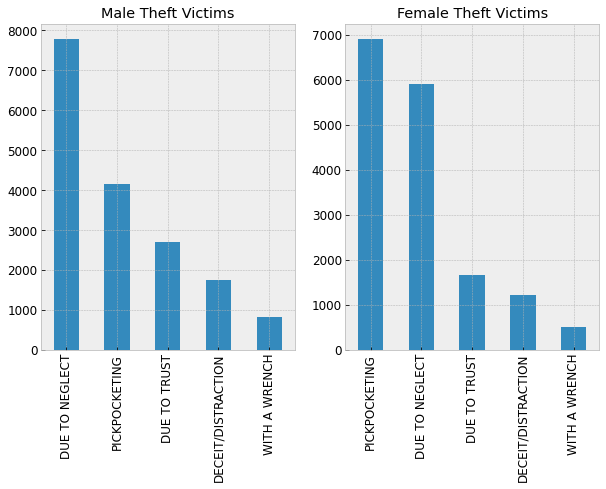

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (10,6))

df[(df["Gender"] == "male") & (df["Crime"] == "THEFT")]["SubtypeCrime"].value_counts()[:5].plot.bar(ax = axes[0], title = "Male Theft Victims")
df[(df["Gender"] == "female") & (df["Crime"] == "THEFT")]["SubtypeCrime"].value_counts()[:5].plot.bar(ax = axes[1], title = "Female Theft Victims")

It is interesting to see how different both categories are. Assault requires some sort of violence whilst theft is mostly using misdirection.

When it comes to comparing both genders, we do not see noticeable differences in the subtypes of most common crime subtypes. Both men and women are susceptible to firearm crimes, showing a clear issue when it comes to gun violence in the country. Pickpocketing and stealing neglected items also seems to be quite a trending type of crime to be accounted for. 

This makes us think that both genders seem to be targetted in similar manner and that it might just be a matter of gender frequency in a specific location.

So... one last plot and then we open the map!

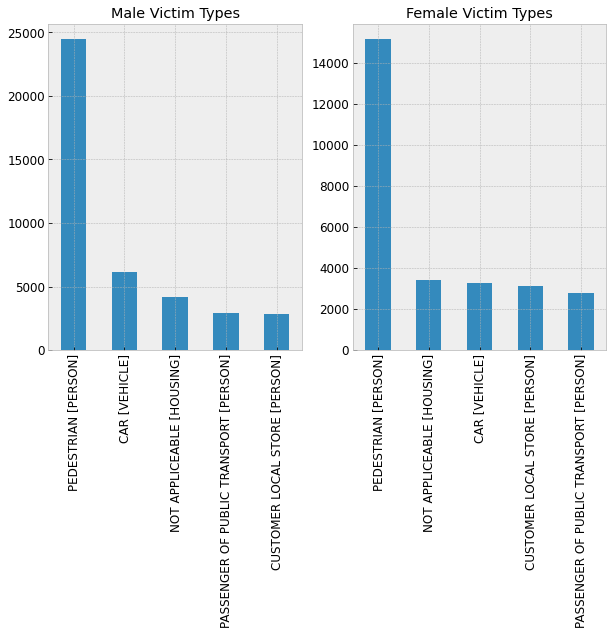

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (10,6))

df[(df["Gender"] == "male")]["SubtypeVictim"].value_counts()[:5].plot.bar(ax = axes[0], title = "Male Victim Types")
df[(df["Gender"] == "female")]["SubtypeVictim"].value_counts()[:5].plot.bar(ax = axes[1], title = "Female Victim Types")

In this last plot we are looking at the type of victims by gender. One can immediately tell that the most common victim is a pedestrian. We will keep this in mind for later on.

Time for some cartography!

#### Canton - San José - Topology

The country of Costa Rica is comprised by 7 provinces

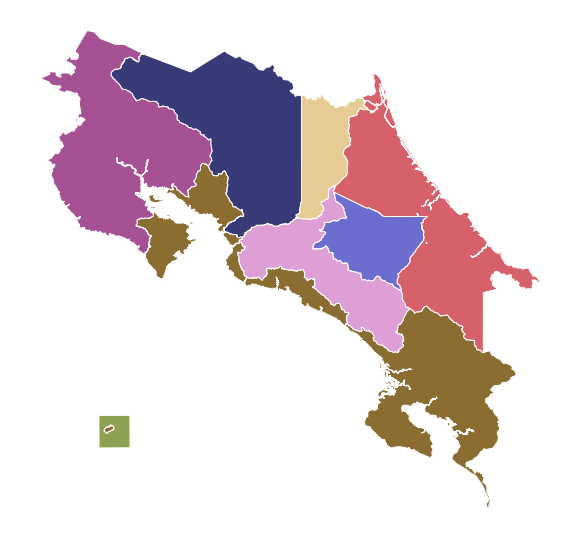

Each of them is divided into cantons and each canton is then divided into districts. There is a total of 82 cantons and 488 in the whole territory.

The canton of San José is located right in the middle of the country.

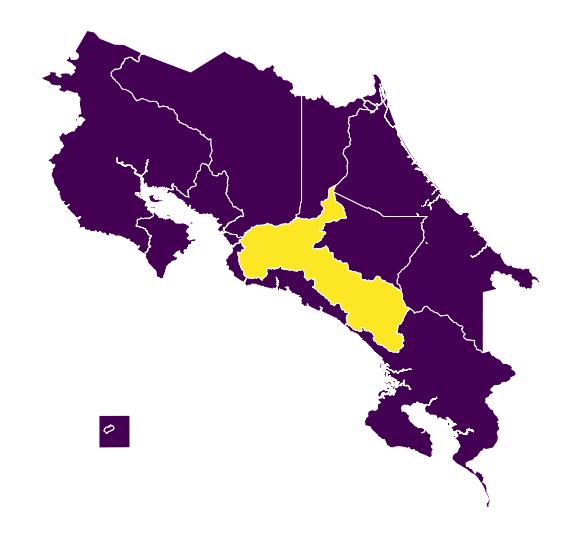

And itself is divided into 11 districts

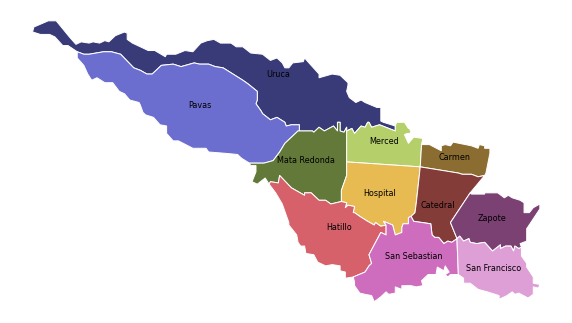

We will now focus in these districts.

#### Canton - San José - Districts

Let's quickly load a custom San José shapefile we created for the challenge to better visualize the data...

In [ ]:
san_jose_og = pd.read_csv("costarica.csv")
san_jose_og["geometry"] = san_jose_og["geometry"].apply(wkt.loads)
san_jose_og["coords"] = san_jose_og["coords"].apply(ast.literal_eval)
san_jose_og = san_jose_og.rename(columns={"Nombre": "District"})
san_jose_og = gpd.GeoDataFrame(san_jose_og, geometry="geometry")

And let's create a simple function to plot the data

In [ ]:
def san_jose_plotted(san_jose_df:pd.DataFrame, column: pd.Series, column_name: str) -> None:
    fig, ax = plt.subplots(figsize = (10,10))
    san_jose = san_jose_df.copy()
    san_jose = pd.merge(san_jose, column.copy(), on='District')
    san_jose.plot(ax=ax, edgecolor='grey', column = column_name, cmap = "hot", legend = True, legend_kwds={'shrink': 0.3})

    for idx, row in san_jose.iterrows():
        plt.annotate(s=row[column_name], xy=row["coords"], horizontalalignment="center", color="white",fontsize = 9)
        

    plt.axis('off')

Let's first look at the possible districts

In [ ]:
df["District"].value_counts()

HOSPITAL                     17675
CATEDRAL                     15945
MERCED                       13398
CARMEN                        9556
PAVAS                         9447
HATILLO                       7554
SAN SEBASTIAN                 7486
URUCA                         6865
MATA REDONDA                  6020
SAN FRANCISCO DE DOS RIOS     4517
ZAPOTE                        4379
DESCONOCIDO                   1445
Name: District, dtype: int64

We see a district labelled as "Desconocido" (unknown in spanish) with a small number of samples. We will remove it.

In [ ]:
df = df[df["District"] != "Desconocido"]

Let's now understand which districts have the highest amount of crimes.

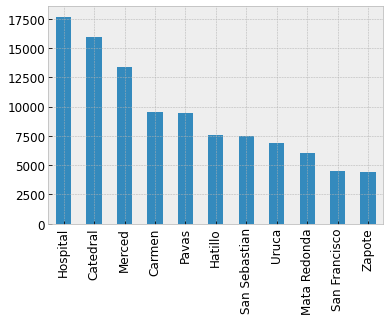

In [ ]:
df["District"] = df["District"].replace("SAN FRANCISCO DE DOS RIOS", "SAN FRANCISCO")
df["District"] = df["District"].apply(lambda x: x.title())
df["District"].value_counts().plot.bar()  

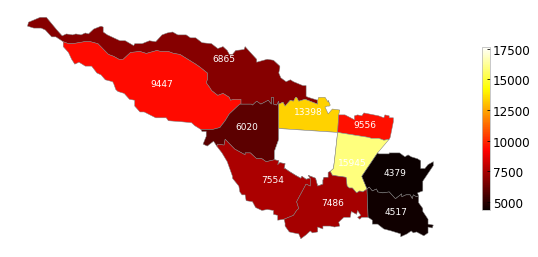

In [ ]:
d = df.groupby("District")["Crime"].count().sort_values(ascending=False).reset_index()

san_jose_plotted(san_jose_og, d, "Crime")

As we can see, the lighter the colour, the higher the amount of total crimes commited in that district. The highest amount of crimes are being commited in Hospital (17500) and the lowest in Zapote (4379).

Our next thought is whether this is related to the overall population of that specific district, so that's what we will compare next using the official 2020 population projection *(data by Wikidata)*.

         District  Projection
0          Carmen        3001
4    Mata Redonda       10066
5          Merced       15203
1        Catedral       15588
10         Zapote       21858
7   San Francisco       23637
3        Hospital       23685
9           Uruca       41724
8   San Sebastián       44930
2         Hatillo       59879
6           Pavas       87827


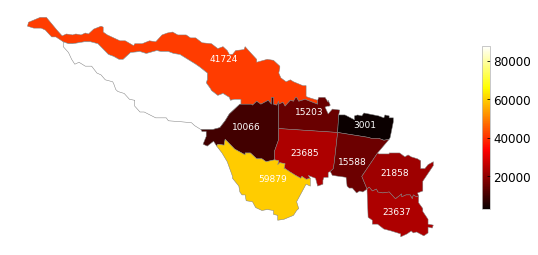

In [ ]:
population = pd.read_csv("san_jose_projection.csv")
population["Projection"] = population["Projection"].apply(lambda x: int(x.replace(",","")))
print(population.sort_values(by="Projection"))
san_jose_plotted(san_jose_og, population, "Projection")

Here we can see the population per district. Pavas is the most populated area, with more than 87000 inhabitants and Carmen the least populated area with 3000. A priori it looks like population and crime rate seem uncorrelated. Let's still plot the heatmap to check.


In [ ]:
temp = pd.merge(d.copy(), population.copy(), on='District')
temp_corr = temp.corr()
temp_corr

Crime  Projection
Crime       1.000000   -0.139827
Projection -0.139827    1.000000

This confirms our findings, population is barely correlated with the amount of crimes (and negatively correlated, which does not make much sense)

We still think there might be some information we are missing here, so let's try analyzing the spacial orientation of each district (the distribution of the directions of the streets in the district).

In [ ]:
places = {
    "Hospital": "Hospital, San Jose, Costa Rica",
    "Zapote": "Zapote, San Jose, Costa Rica",
    "Mata Redonda": "Mata Redonda, San Jose, Costa Rica",
    "Uruca": "Uruca, San Jose, Costa Rica",
    "San Sebastian": "San Sebastian, San Jose, Costa Rica",
    "Hatillo": "Hatillo, San Jose, Costa Rica",
    "Pavas": "Pavas, San Jose, Costa Rica",
    "Carmen": "Carmen, San Jose, Costa Rica",
    "Merced": "Merced, San Jose, Costa Rica",
    "Catedral": "Catedral, San Jose, Costa Rica",
    "San Francisco": "San Francisco de dos Rios, San Jose, Costa Rica",
}
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={"projection": "polar"})

distributions = {}
# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    print(ox.utils.ts(), place)

    # get undirected graphs with edge bearing attributes
    G = ox.graph_from_place(place, network_type="walk")
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    distributions[place] = Gu
    fig, ax = ox.bearing.plot_orientation(Gu, ax=ax, title=place, area=True)

# add figure title and save image
suptitle_font = {
    "family": "DejaVu Sans",
    "fontsize": 60,
    "fontweight": "normal",
    "y": 1,
}
fig.suptitle("District Street Network Orientation", **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
plt.close()

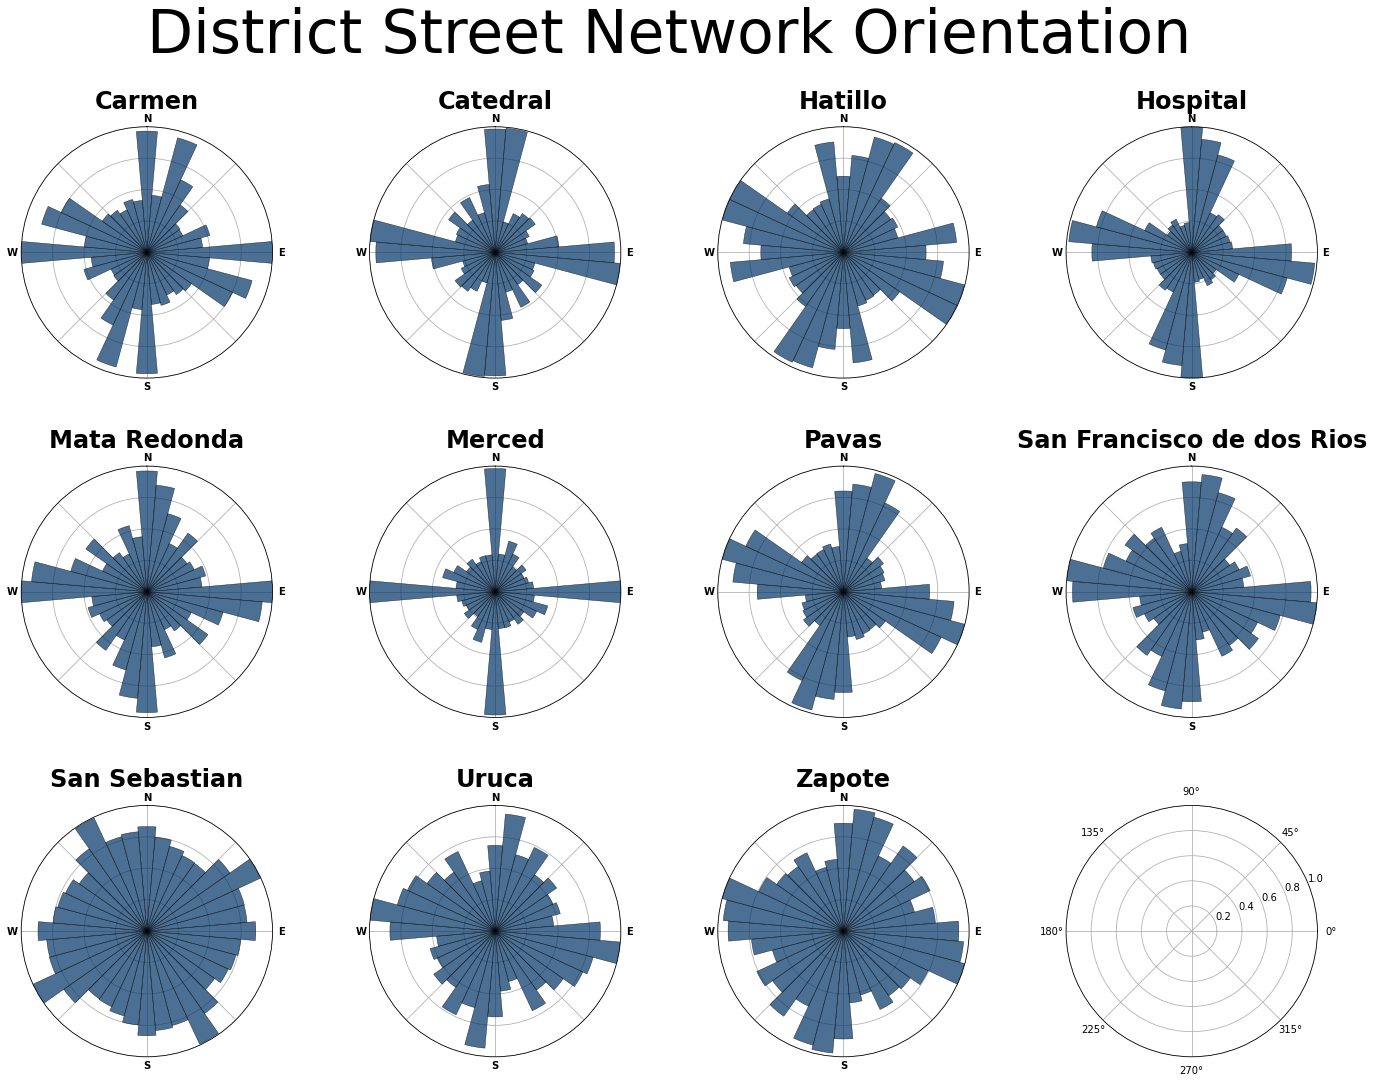

Here we can see the different angles in which the streets are laid out in each of the districts and the street lengths.

It is really interesting to see that Hospital, Catedral and Merced, the districts with the highest amount of crimes, are also the most quadriculated districts. Let's compute the entropy of the orientation and see if it really correlates with the crime count (the entropy expresses this spread and distance as a metric so we can compare it to the crimes quantitatively).

In [ ]:
distributions_list = []

for key, value in distributions.items():
    distributions[key] = ox.bearing.orientation_entropy(value)
    distributions_list.append({"District":key, "Entropy":value})
temp = pd.merge(d.copy(), pd.DataFrame(distributions_list), on='District')
temp_corr = temp.corr()
temp_corr


Crime   Entropy
Crime    1.000000 -0.806082
Entropy -0.806082  1.000000

This confirms our hypothesis regarding the correlation between the street distribution and the crime rate.

Another idea we have is checking whether the crime rate is somewhat correlated to the number of parks or even police stations in the area. Let's look into that!


In [ ]:
parks = {}
# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    print(ox.utils.ts(), place)

    tag = {"leisure": "park"}
    G = ox.geometries_from_place(place, tag)
    parks[place] = G["geometry"].count()


In [ ]:
parks_list = []

for key, value in parks.items():
    parks_list.append({"District":key, "Parks":value})
temp = pd.merge(d.copy(), pd.DataFrame(parks_list), on='District')
temp_corr = temp.corr()
temp_corr

Crime     Parks
Crime  1.000000 -0.351572
Parks -0.351572  1.000000

The number of parks seems to be negatively correlated. This can be a bit counterintuitive, as one could asume parks to be a place with little control where it is easier to be victim of a crime. We are not computing the area of the parks, so this could change.

Let's now look at police related organisms.

In [ ]:
amenities = {}
# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    print(ox.utils.ts(), place)

    tag = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
    G = ox.geometries_from_place(place, tag)
    amenities[place] = G


In [ ]:
police_list = []

for key, value in amenities.items():

    police_list.append({"District":key, "Police":value[value["amenity"] == "police"].dropna(axis=1, how="any")["geometry"].count()})
temp = pd.merge(d.copy(), pd.DataFrame(police_list), on='District')
temp_corr = temp.corr()
temp_corr

Crime    Police
Crime   1.000000 -0.098483
Police -0.098483  1.000000

Interestingly, the number of police-related organisms is not correlated to the number of crimes. This could be due to the dataset containing many bureaucratic organisms that are still labeled as police-related organisms.

There is a list of other amenities that we can also compute and check if they are somehow correlated to the number of crimes. Let's do that.

In [ ]:
amenities_list = []

for key, value in amenities.items():
    amenity = {"District":key}
    for amenity_type in value['amenity'].unique():
        val = value[value["amenity"] == amenity_type].dropna(axis=1, how="any")["geometry"].count()
        amenity[amenity_type] = val
    amenities_list.append(amenity)
temp = pd.merge(d.copy(), pd.DataFrame(amenities_list), on='District')
temp = temp.fillna(0)
temp_corr = temp.corr()
temp_corr["Crime"].reindex(temp_corr["Crime"].abs().sort_values().index)[-5:-2]

conference_centre   -0.430863
driving_school       0.581230
internet_cafe        0.822207
Name: Crime, dtype: float64

Here we can see the top 3 most correlated amenities with crime. Really interesting how internet cafes seem to be the most correlated type of amenity.

To finish our analysis, let's now look at the frequency of these crimes and when they tend to happen.

In order to do this we need to modify de dataframe a bit. Let's start with that.

#### Canon - San José - Daily

In [ ]:
df.drop(columns=['Unnamed: 0', 'Time', 'Province', 'Canton'], inplace=True)
unique_times = df['Date'].unique()
print(f'Number of unique times: {unique_times.shape[0]}')
print(f'Earliest date: {unique_times.min()}')
print(f'Latest date: {unique_times.max()}')

Number of unique times: 31786
Earliest date: 2010-01-01T00:00:00.000000000
Latest date: 2022-04-14T18:00:00.000000000


Our first step is to pivot the dataframe. This way we can see the number of crimes commited by district over time.

In [ ]:
pivot = df.pivot_table('ID', aggfunc=np.size, columns='District', index=df.index, fill_value=0)
pivot

District             CARMEN  CATEDRAL  DESCONOCIDO  HATILLO  HOSPITAL  \
Date                                                                    
2010-01-01 00:00:00       1         1            0        0         1   
2010-01-01 03:00:00       0         0            0        0         0   
2010-01-01 09:00:00       0         0            0        0         0   
2010-01-01 18:00:00       0         0            0        0         0   
2010-01-01 21:00:00       0         0            0        1         0   
...                     ...       ...          ...      ...       ...   
2022-04-13 18:00:00       0         0            0        0         1   
2022-04-14 09:00:00       1         0            0        0         0   
2022-04-14 12:00:00       0         1            0        0         0   
2022-04-14 15:00:00       1         0            0        0         0   
2022-04-14 18:00:00       0         0            0        0         0   

District             MATA REDONDA  MERCED  PAVAS  SAN FRANCISCO DE DOS RIOS  \
Date                                                                          
2010-01-01 00:00:00             0       1      0                          0   
2010-01-01 03:00:00             0       1      0                          0   
2010-01-01 09:00:00             0       1      0                          0   
2010-01-01 18:00:00             0       0      0                          0   
2010-01-01 21:00:00             0       0      0                          0   
...                           ...     ...    ...                        ...   
2022-04-13 18:00:00             0       0      0                          0   
2022-04-14 09:00:00             0       0      0                          0   
2022-04-14 12:00:00             0       0      0                          0   
2022-04-14 15:00:00             0       0      1                          0   
2022-04-14 18:00:00             0       0      0                          2   

District             SAN SEBASTIAN  URUCA  ZAPOTE  
Date                                               
2010-01-01 00:00:00              0      0       0  
2010-01-01 03:00:00              1      1       0  
2010-01-01 09:00:00              0      0       0  
2010-01-01 18:00:00              0      0       1  
2010-01-01 21:00:00              0      0       0  
...                            ...    ...     ...  
2022-04-13 18:00:00              0      0       0  
2022-04-14 09:00:00              0      0       0  
2022-04-14 12:00:00              0      0       0  
2022-04-14 15:00:00              0      0       0  
2022-04-14 18:00:00              0      0       0  

[31786 rows x 12 columns]

Let's just see an overview of the crimes by district over time.

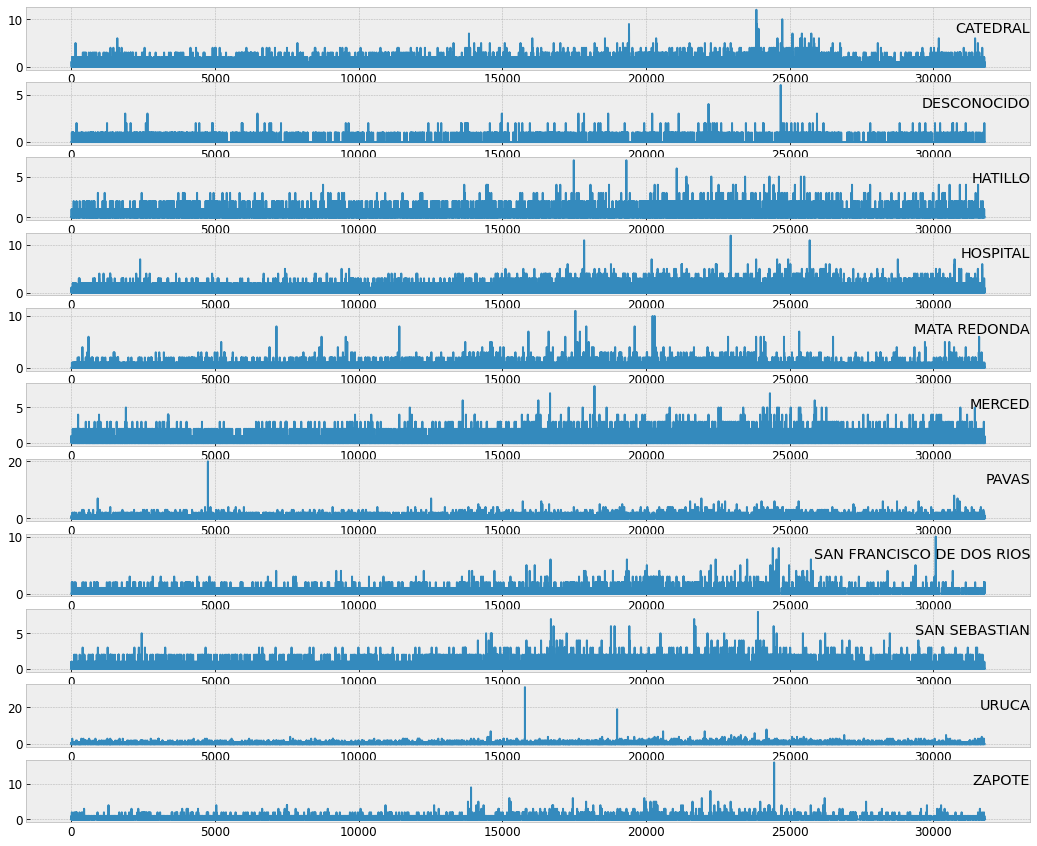

In [ ]:
rcParams['figure.figsize'] = 18, 15
values = pivot.values
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(pivot.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

A priori we cannot observe any significant trend. Let's analyze one specific district to see if this hypothesis holds.

We will analyze the district of Hospital. This district has the highest amount of cases, so it also makes sense to start with it.

Hospital

<Figure size 4000x1600 with 0 Axes>

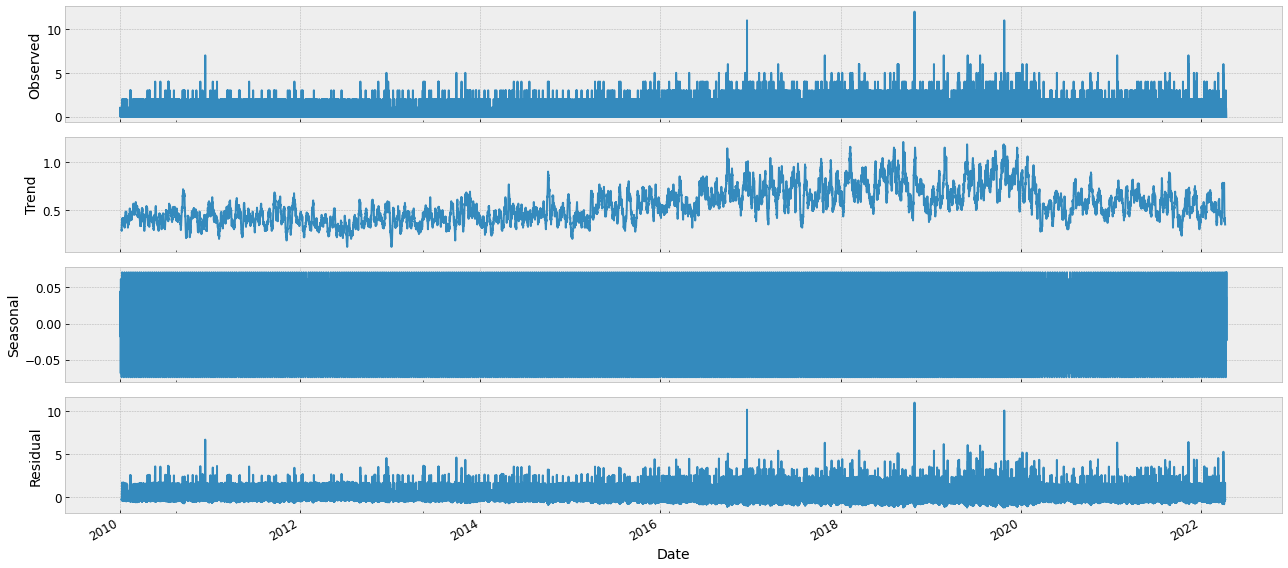

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = pivot['HOSPITAL']
result = seasonal_decompose(series, model='additive', freq = 60)
res = result.plot()

This test seems to prove our hypothesis. The is a slight increasing trend at the beginning but it then seems to go back down. However, let's do one last test and check stationarity.

To do this, we will perform a Dickey-Fuller test with Hospital as our target.

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=8760).mean()
        rolstd = y.rolling(window=8760).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')

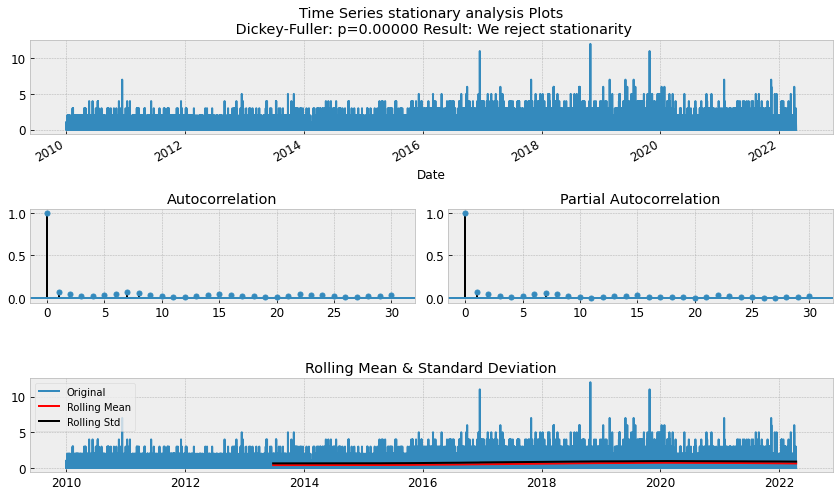

In [ ]:
tsplot(pivot['HOSPITAL'], lags=30)

There is clearly no stationarity and no linear relationship between crimes over time.

This is not surprising, as a crime commited at 1pm should not have an impact on a crime commited a 10pm.

Let's now look at how the crime rate behaves on a daily basis.

In [ ]:
pivot

District             CARMEN  CATEDRAL  DESCONOCIDO  HATILLO  HOSPITAL  \
Date                                                                    
2010-01-01 00:00:00       1         1            0        0         1   
2010-01-01 03:00:00       0         0            0        0         0   
2010-01-01 09:00:00       0         0            0        0         0   
2010-01-01 18:00:00       0         0            0        0         0   
2010-01-01 21:00:00       0         0            0        1         0   
...                     ...       ...          ...      ...       ...   
2022-04-13 18:00:00       0         0            0        0         1   
2022-04-14 09:00:00       1         0            0        0         0   
2022-04-14 12:00:00       0         1            0        0         0   
2022-04-14 15:00:00       1         0            0        0         0   
2022-04-14 18:00:00       0         0            0        0         0   

District             MATA REDONDA  MERCED  PAVAS  SAN FRANCISCO DE DOS RIOS  \
Date                                                                          
2010-01-01 00:00:00             0       1      0                          0   
2010-01-01 03:00:00             0       1      0                          0   
2010-01-01 09:00:00             0       1      0                          0   
2010-01-01 18:00:00             0       0      0                          0   
2010-01-01 21:00:00             0       0      0                          0   
...                           ...     ...    ...                        ...   
2022-04-13 18:00:00             0       0      0                          0   
2022-04-14 09:00:00             0       0      0                          0   
2022-04-14 12:00:00             0       0      0                          0   
2022-04-14 15:00:00             0       0      1                          0   
2022-04-14 18:00:00             0       0      0                          2   

District             SAN SEBASTIAN  URUCA  ZAPOTE  
Date                                               
2010-01-01 00:00:00              0      0       0  
2010-01-01 03:00:00              1      1       0  
2010-01-01 09:00:00              0      0       0  
2010-01-01 18:00:00              0      0       1  
2010-01-01 21:00:00              0      0       0  
...                            ...    ...     ...  
2022-04-13 18:00:00              0      0       0  
2022-04-14 09:00:00              0      0       0  
2022-04-14 12:00:00              0      0       0  
2022-04-14 15:00:00              0      0       0  
2022-04-14 18:00:00              0      0       0  

[31786 rows x 12 columns]

In [ ]:
palette = cycle(px.colors.sequential.Viridis)
#pivot = pivot.reset_index()
df_graph = pivot[['Date', 'Total']]

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "scatter"}], [{"colspan": 2}, None]],
                    column_widths=[0.4, 0.6], vertical_spacing=0.1, horizontal_spacing=0.1,
                    subplot_titles=("Crimes per Day of Week", "Hourly Crimes Trend", "Daily Crimes Trend"))

# Upper Left chart
df_day = df_graph.groupby([df_graph["Date"].dt.weekday]).mean().reset_index().sort_values(by='Total', ascending = False)
values = list(range(7))
fig.add_trace(go.Bar(x=df_day["Date"], y=df_day['Total'], marker = dict(color=values, colorscale="Viridis"), 
                     name = 'Day of Week'),
                      row=1, col=1)
fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=1)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=1)

# Upper Right chart
df_hour = pd.read_csv('hours.csv')
fig.add_trace(go.Scatter(x=df_hour["Date"], y=df_hour['Total'], mode='lines+markers',
               name='Hourly Crimes'), row = 1, col = 2)

# Rectangle to highlight range
fig.add_vrect(x0=17, x1=21,
              fillcolor=px.colors.sequential.Viridis[4],
              layer="below", 
              opacity=0.25, 
              line_width=0, 
              row = 1, col = 2
)

fig.add_annotation(dict(
        x=8.5,
        y=0,
        text="<br><b>Morning hours</b>.",
        showarrow = False
), row=1, col=2)

fig.add_annotation(dict(
        x=17,
        y=0,
        text="<br><b>Evening hours</b>.",
        showarrow = False
), row=1, col=2)

fig.add_annotation(dict(
        x=18,
        y=df_hour.loc[18,'Total'],
        text="Between <br> <b>6pm and 9 pm occurr the most crimes<br> </b>.",
        ax="0",
        ay="-50",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=1, col=2)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=2)
fig.update_yaxes(showgrid = False, linecolor='gray', linewidth=2, row=1, col=2)

# Medium Chart
df_week = df_graph.groupby([df_graph["Date"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week["Date"], y = df_week['Total'], mode='lines',
                        marker = dict(color = px.colors.sequential.Viridis[5]),
                        name='Daily Validations'), row = 2, col = 1)

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_week['Total'], model='additive', freq = 21)

fig.add_trace(go.Scatter(x = df_week["Date"], y = decomp.trend, mode='lines',
                       marker = dict(color = medium),
                        name='Trend'), row = 2, col = 1)
    
fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, row=2, col=1)
fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.15, linecolor='gray',linewidth=2, row=2, col=1)

# General Styling
fig.update_layout(height=650, width=1000, bargap=0.2,
                  margin=dict(b=50,r=30,l=100),
                  title = "<span style='font-size:36px; font-family:Times New Roman'>Validations Analysis</span>",                  
                  plot_bgcolor='rgb(242,242,242)',
                  paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)
fig.show()

z = df_graph.groupby([df_graph["Date"].dt.date])['Total'].mean()
display_years(z, (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022))



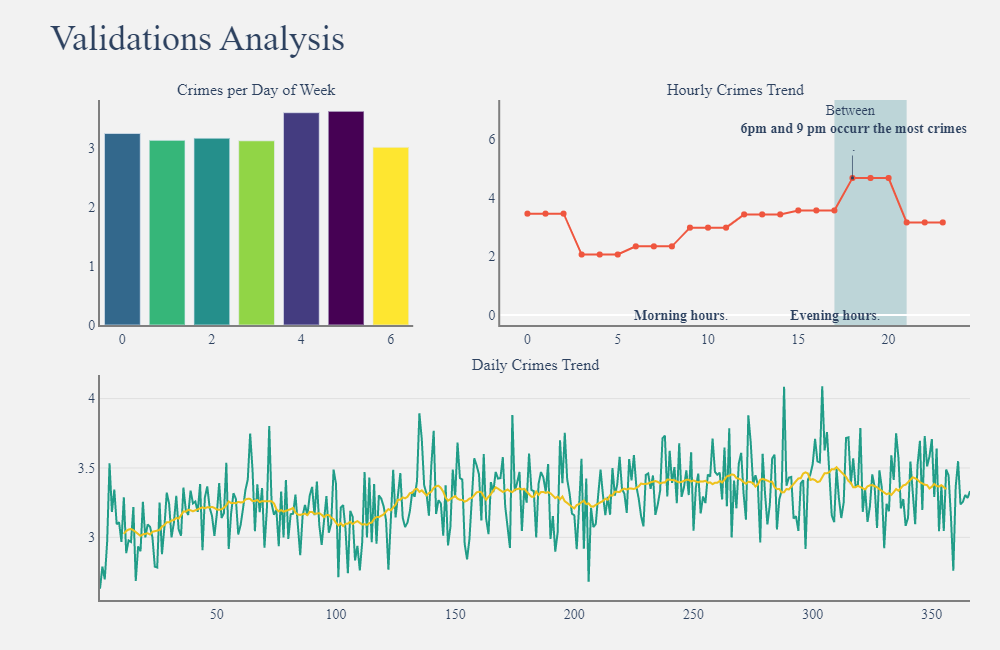
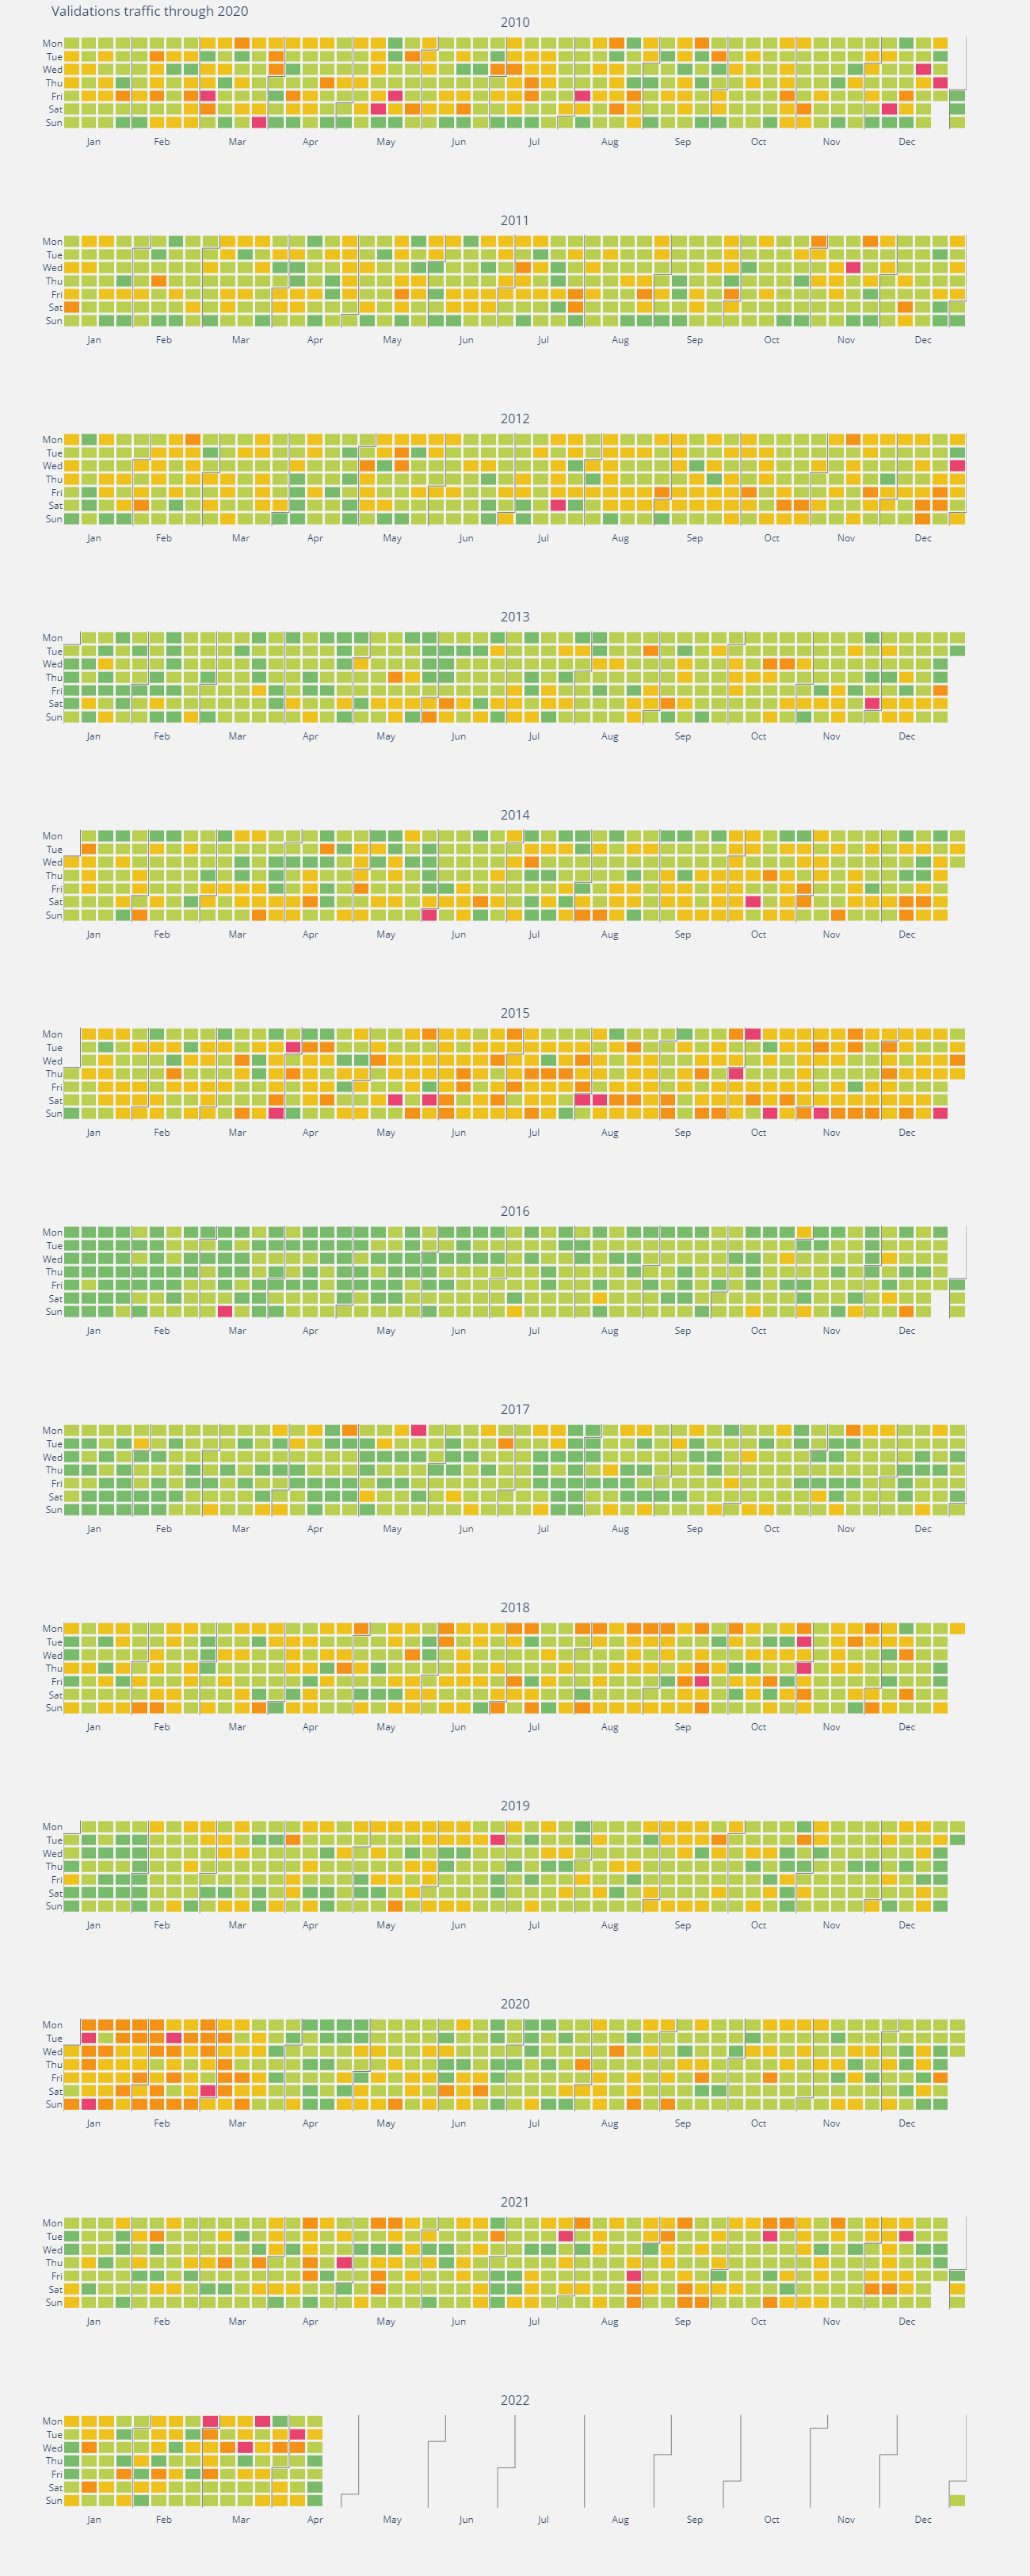

Here we obtain some interesting information regarding the crime patterns. 
- Most crimes are commited on Fridays and Saturdays
- Most crimes are commited between 6pm and 9pm
- 2016 registered a surprisingly low amount of crimes

Our conclusions from these plots are in line with the type of victims analyzed before. Given that most of them are pedestrians, it also makes sense that most of the crimes are commited while people are coming back from work or in their way to do their evening chores (going to the supermarket, leisure time, etc, activities that imply a journey).

We have all the information we need, let's now build some models!

### Modelling

Trying to model crime patterns is a relatively futile task with the data we are provided. 

Crime pattern theory (Brantingham and Brantingham 1984, 1993) suggests that rather than actively searching for crime opportunities in locations that are unfamiliar, offenders commit offenses in areas that are already known to them. 

Also, from a crime pattern theory perspective, more crime would be expected to occur on (or near to) more “central” (to use the terminology of graph theory) street segments. 

This makes predicting crime without coordinates of the crime locations quite achallenging task.

We'll do our best and see what we can obtain!

Let's start by splitting the data and doing some feature engineering.


In [ ]:
def add_datetime_features(df):
    df['year']    = df['Date'].dt.year
    df['month']   = df['Date'].dt.month
    df['day']     = df['Date'].dt.day
    df['week']    = (df['Date'].dt.isocalendar().week).astype("int")
    df['weekday'] = df['Date'].dt.weekday
    df['weekend'] = (df['Date'].dt.weekday >= 5).astype("int")
    df['hour']    = df['Date'].dt.hour
    df['morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype("int")
    df['afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype("int")
    df['night'] = ((df['hour'] >= 18) & (df['hour'] >= 0) & (df['hour'] < 6)).astype("int")

def get_train_data(df):
  #df = df.drop(df.columns.difference(['Date', target]), 1)
  train_df = df[(df["Date"].dt.year > 2010) & (df["Date"].dt.month < 2021)]
  test_df = df[df["Date"].dt.year == 2021]
  
  add_datetime_features(train_df)
  add_datetime_features(test_df)

  targets = df.columns.difference(['Date'])

  X_train = train_df.copy()
  X_train = X_train.drop(['Date'], axis=1)
  Y_train = X_train[targets]
  X_train = X_train.drop(targets, axis=1)

  X_test = test_df.copy()
  X_test = X_test.drop(['Date'], axis=1)
  Y_test = X_test[targets]
  X_test = X_test.drop(targets, axis=1)

  return X_train, Y_train, X_test, Y_test

We will use 2021 as our test data and all the dates before that as our training data.

In [ ]:
pivot['Total'] = pivot.sum(numeric_only=True, axis=1) 
pivot['Average'] = pivot.mean(numeric_only=True, axis=1)
#pivot.nlargest(10, 'Total')

In [ ]:
pivot.reset_index(inplace = True)
X_train, Y_train, X_test, Y_test = get_train_data(pivot)

In [ ]:
Y_train

District   Average  CARMEN  CATEDRAL  DESCONOCIDO  HATILLO  HOSPITAL  \
2533      1.076923       2         0            0        1         1   
2534      0.307692       0         0            0        0         2   
2535      0.307692       0         1            0        0         1   
2536      0.307692       0         0            0        1         0   
2537      0.923077       0         0            0        0         3   
...            ...     ...       ...          ...      ...       ...   
31781     0.153846       0         0            0        0         1   
31782     0.153846       1         0            0        0         0   
31783     0.153846       0         1            0        0         0   
31784     0.307692       1         0            0        0         0   
31785     0.307692       0         0            0        0         0   

District  MATA REDONDA  MERCED  PAVAS  SAN FRANCISCO DE DOS RIOS  \
2533                 0       0      2                          0   
2534                 0       0      0                          0   
2535                 0       0      0                          0   
2536                 0       1      0                          0   
2537                 0       0      1                          0   
...                ...     ...    ...                        ...   
31781                0       0      0                          0   
31782                0       0      0                          0   
31783                0       0      0                          0   
31784                0       0      1                          0   
31785                0       0      0                          2   

District  SAN SEBASTIAN  Total  URUCA  ZAPOTE  
2533                  1      7      0       0  
2534                  0      2      0       0  
2535                  0      2      0       0  
2536                  0      2      0       0  
2537                  0      6      1       1  
...                 ...    ...    ...     ...  
31781                 0      1      0       0  
31782                 0      1      0       0  
31783                 0      1      0       0  
31784                 0      2      0       0  
31785                 0      2      0       0  

[29253 rows x 14 columns]

This will be our first approach. We will try predicting for each time frame the total number of crimes in each district. This will be tough 

Let's check the mutual infiormation of the features to see which features are the most relevant.

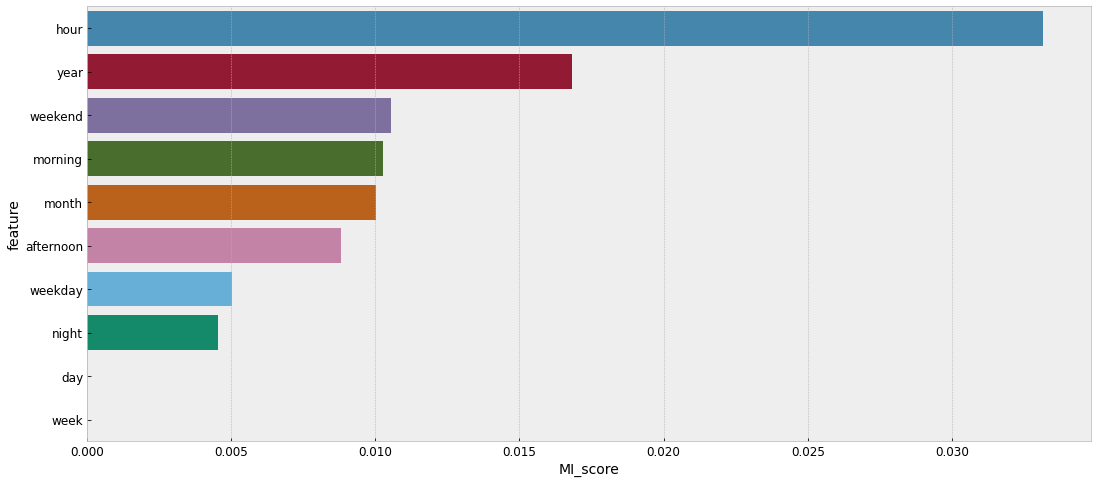

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns

# Mutual Information does not support Nans, we filled them with 0
Xmi_train = X_train.fillna(0)

mi_scores = mutual_info_regression(Xmi_train[:52173], Y_train['Total'])
mi_scores = pd.Series(mi_scores, name="MI_score", index=Xmi_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
df_mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'District':'feature'})

sns.barplot(y=df_mi_scores['feature'].loc[:20], x=df_mi_scores['MI_score'].loc[:20])

Now we model with the features we chose in the last section. We train a MultiOutputRegressor which fits one regressor for each district. 

Let's see how it performs!

In [ ]:
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor()).fit(X_train, Y_train)

Let's run the model over our test set and see how it performs.

In [ ]:
preds = multioutputregressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.676871


This metric, the RMSE, tells us the standard deviation of the prediction. The lower, the better. 

An RMSE of 0.68 is surprisingly low given our initial hypothesis.


**YEARLY PREDICTION FOR 2021**

         District  Yearly
9   San Francisco     196
13         Zapote     216
6    Mata Redonda     320
12          Uruca     440
10  San Sebastian     459
4         Hatillo     514
1          Carmen     586
8           Pavas     735
2        Catedral     972
7          Merced    1108
5        Hospital    1417


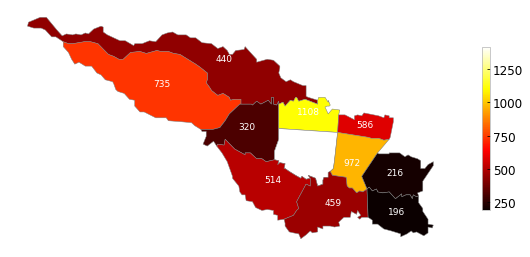

In [ ]:
result = pd.DataFrame()
result["District"] = list(Y_train.columns)
result["District"] = result["District"].apply(lambda x: x.title())
result["District"] = result["District"].apply(lambda x: x.replace("San Francisco De Dos Rios","San Francisco"))
result["Yearly"] = sum(preds)
result["Yearly"] = result["Yearly"].apply(int)
result = result[~result["District"].isin(["Desconocido","Average","Total"])]
print(result.sort_values(by="Yearly"))
san_jose_plotted(san_jose_og, result, "Yearly")

Here we can see the yearly predictions for 2021!

In [ ]:
trim1 = preds[0:600]
trim2 = preds[600:1200]
trim3 = preds[1200:1800]
trim4 = preds[1800:]

FIRST TRIMESTER OF 2021

         District  Yearly
9   San Francisco      48
13         Zapote      53
6    Mata Redonda      81
12          Uruca     104
10  San Sebastian     120
4         Hatillo     122
1          Carmen     156
8           Pavas     173
2        Catedral     214
7          Merced     261
5        Hospital     356


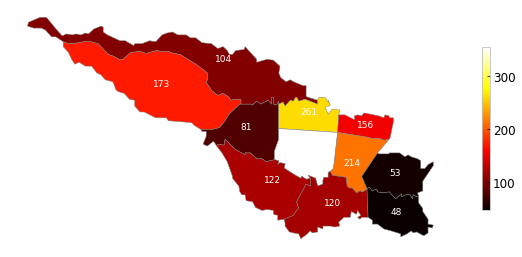

In [ ]:
result = pd.DataFrame()
result["District"] = list(Y_train.columns)
result["District"] = result["District"].apply(lambda x: x.title())
result["District"] = result["District"].apply(lambda x: x.replace("San Francisco De Dos Rios","San Francisco"))
result["Yearly"] = sum(trim1)
result["Yearly"] = result["Yearly"].apply(int)
result = result[~result["District"].isin(["Desconocido","Average","Total"])]
print(result.sort_values(by="Yearly"))
san_jose_plotted(san_jose_og, result, "Yearly")

SECOND TRIMESTER OF 2021

         District  Yearly
13         Zapote      55
9   San Francisco      56
6    Mata Redonda      68
12          Uruca     109
10  San Sebastian     120
4         Hatillo     122
1          Carmen     139
8           Pavas     176
2        Catedral     232
7          Merced     265
5        Hospital     342


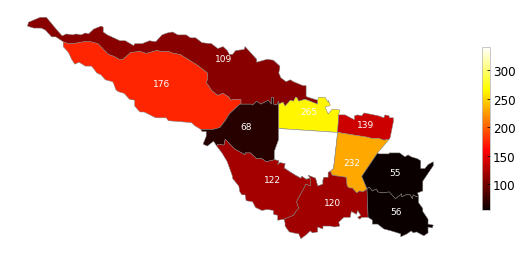

In [ ]:
result = pd.DataFrame()
result["District"] = list(Y_train.columns)
result["District"] = result["District"].apply(lambda x: x.title())
result["District"] = result["District"].apply(lambda x: x.replace("San Francisco De Dos Rios","San Francisco"))
result["Yearly"] = sum(trim2)
result["Yearly"] = result["Yearly"].apply(int)
result = result[~result["District"].isin(["Desconocido","Average","Total"])]
print(result.sort_values(by="Yearly"))
san_jose_plotted(san_jose_og, result, "Yearly")

THIRD TRIMESTER OF 2021

         District  Yearly
9   San Francisco      49
13         Zapote      51
6    Mata Redonda      69
10  San Sebastian     106
12          Uruca     107
4         Hatillo     125
1          Carmen     136
8           Pavas     178
2        Catedral     249
7          Merced     271
5        Hospital     339


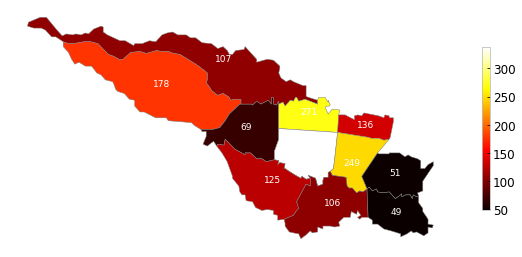

In [ ]:
result = pd.DataFrame()
result["District"] = list(Y_train.columns)
result["District"] = result["District"].apply(lambda x: x.title())
result["District"] = result["District"].apply(lambda x: x.replace("San Francisco De Dos Rios","San Francisco"))
result["Yearly"] = sum(trim3)
result["Yearly"] = result["Yearly"].apply(int)
result = result[~result["District"].isin(["Desconocido","Average","Total"])]
print(result.sort_values(by="Yearly"))
san_jose_plotted(san_jose_og, result, "Yearly")

FOURTH TRIMESTER OF 2021

         District  Yearly
9   San Francisco      42
13         Zapote      55
6    Mata Redonda     101
10  San Sebastian     112
12          Uruca     118
4         Hatillo     144
1          Carmen     155
8           Pavas     206
2        Catedral     276
7          Merced     310
5        Hospital     379


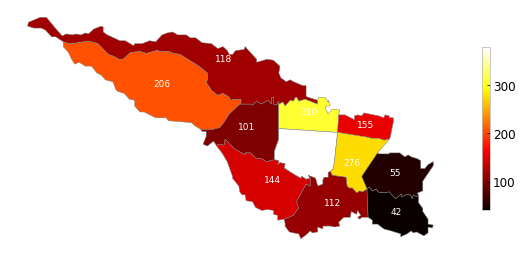

In [ ]:
result = pd.DataFrame()
result["District"] = list(Y_train.columns)
result["District"] = result["District"].apply(lambda x: x.title())
result["District"] = result["District"].apply(lambda x: x.replace("San Francisco De Dos Rios","San Francisco"))
result["Yearly"] = sum(trim4)
result["Yearly"] = result["Yearly"].apply(int)
result = result[~result["District"].isin(["Desconocido","Average","Total"])]
print(result.sort_values(by="Yearly"))
san_jose_plotted(san_jose_og, result, "Yearly")

There are some slight differences between trimesters but they all follow the same pattern.

Finally, lets train a model using only the female victim crimes and see how it performs in comparison.

In [ ]:
df_women

Crime       SubtypeCrime                Date  \
Date                                                                            
2022-01-08 06:00:00            ASSAULT        COLD WEAPON 2022-01-08 06:00:00   
2022-01-13 15:00:00            ASSAULT        COLD WEAPON 2022-01-13 15:00:00   
2022-01-17 18:00:00            ASSAULT        COLD WEAPON 2022-01-17 18:00:00   
2022-02-05 12:00:00            ASSAULT        COLD WEAPON 2022-02-05 12:00:00   
2022-02-05 18:00:00            ASSAULT        COLD WEAPON 2022-02-05 18:00:00   
...                                ...                ...                 ...   
2010-07-17 06:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-07-17 06:00:00   
2010-07-21 21:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-07-21 21:00:00   
2010-07-04 18:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-07-04 18:00:00   
2010-11-10 21:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-11-10 21:00:00   
2010-11-26 15:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-11-26 15:00:00   

                               SubtypeVictim       Age  Gender  \
Date                                                             
2022-01-08 06:00:00  LOTTERY SELLER [PERSON]   >18 y/o  female   
2022-01-13 15:00:00      PEDESTRIAN [PERSON]   >18 y/o  female   
2022-01-17 18:00:00      PEDESTRIAN [PERSON]   >18 y/o  female   
2022-02-05 12:00:00      PEDESTRIAN [PERSON]   >18 y/o  female   
2022-02-05 18:00:00      PEDESTRIAN [PERSON]   unknown  female   
...                                      ...       ...     ...   
2010-07-17 06:00:00            CAR [VEHICLE]  > 60 y/o  female   
2010-07-21 21:00:00       MICROBUS [VEHICLE]   >18 y/o  female   
2010-07-04 18:00:00            CAR [VEHICLE]   >18 y/o  female   
2010-11-10 21:00:00            CAR [VEHICLE]   >18 y/o  female   
2010-11-26 15:00:00     RURAL 4X4 [VEHICULE]   >18 y/o  female   

                        Nationality  District      ID  
Date                                                   
2022-01-08 06:00:00      COSTA RICA  HOSPITAL       0  
2022-01-13 15:00:00      COSTA RICA  HOSPITAL       4  
2022-01-17 18:00:00         UCRANIA     PAVAS       5  
2022-02-05 12:00:00       NICARAGUA  HOSPITAL      50  
2022-02-05 18:00:00      COSTA RICA    MERCED      52  
...                             ...       ...     ...  
2010-07-17 06:00:00  ESTADOS UNIDOS   HATILLO  648011  
2010-07-21 21:00:00      COSTA RICA  CATEDRAL  648019  
2010-07-04 18:00:00          MEXICO     PAVAS  648087  
2010-11-10 21:00:00      COSTA RICA  CATEDRAL  648164  
2010-11-26 15:00:00      COSTA RICA    CARMEN  648180  

[37405 rows x 9 columns]

In [ ]:
df_women = df[df["Gender"] == "female"]
df_women['ID'] = np.arange(len(df_women))
df_women.index = pd.DatetimeIndex(df_women.Date)

In [ ]:
df_women

Crime       SubtypeCrime                Date  \
Date                                                                            
2022-01-08 06:00:00            ASSAULT        COLD WEAPON 2022-01-08 06:00:00   
2022-01-13 15:00:00            ASSAULT        COLD WEAPON 2022-01-13 15:00:00   
2022-01-17 18:00:00            ASSAULT        COLD WEAPON 2022-01-17 18:00:00   
2022-02-05 12:00:00            ASSAULT        COLD WEAPON 2022-02-05 12:00:00   
2022-02-05 18:00:00            ASSAULT        COLD WEAPON 2022-02-05 18:00:00   
...                                ...                ...                 ...   
2010-07-17 06:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-07-17 06:00:00   
2010-07-21 21:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-07-21 21:00:00   
2010-07-04 18:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-07-04 18:00:00   
2010-11-10 21:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-11-10 21:00:00   
2010-11-26 15:00:00  VEHICLE VANDALISM  VEHICLE VANDALISM 2010-11-26 15:00:00   

                               SubtypeVictim       Age  Gender  \
Date                                                             
2022-01-08 06:00:00  LOTTERY SELLER [PERSON]   >18 y/o  female   
2022-01-13 15:00:00      PEDESTRIAN [PERSON]   >18 y/o  female   
2022-01-17 18:00:00      PEDESTRIAN [PERSON]   >18 y/o  female   
2022-02-05 12:00:00      PEDESTRIAN [PERSON]   >18 y/o  female   
2022-02-05 18:00:00      PEDESTRIAN [PERSON]   unknown  female   
...                                      ...       ...     ...   
2010-07-17 06:00:00            CAR [VEHICLE]  > 60 y/o  female   
2010-07-21 21:00:00       MICROBUS [VEHICLE]   >18 y/o  female   
2010-07-04 18:00:00            CAR [VEHICLE]   >18 y/o  female   
2010-11-10 21:00:00            CAR [VEHICLE]   >18 y/o  female   
2010-11-26 15:00:00     RURAL 4X4 [VEHICULE]   >18 y/o  female   

                        Nationality  District     ID  
Date                                                  
2022-01-08 06:00:00      COSTA RICA  HOSPITAL      0  
2022-01-13 15:00:00      COSTA RICA  HOSPITAL      1  
2022-01-17 18:00:00         UCRANIA     PAVAS      2  
2022-02-05 12:00:00       NICARAGUA  HOSPITAL      3  
2022-02-05 18:00:00      COSTA RICA    MERCED      4  
...                             ...       ...    ...  
2010-07-17 06:00:00  ESTADOS UNIDOS   HATILLO  37400  
2010-07-21 21:00:00      COSTA RICA  CATEDRAL  37401  
2010-07-04 18:00:00          MEXICO     PAVAS  37402  
2010-11-10 21:00:00      COSTA RICA  CATEDRAL  37403  
2010-11-26 15:00:00      COSTA RICA    CARMEN  37404  

[37405 rows x 9 columns]

In [ ]:
pivot = df_women.pivot_table('ID', aggfunc=np.size, columns='District', index=df_women.index, fill_value=0)


In [ ]:
pivot['Total'] = pivot.sum(numeric_only=True, axis=1) 
pivot['Average'] = pivot.mean(numeric_only=True, axis=1)
pivot.reset_index(inplace = True)
X_train, Y_train, X_test, Y_test = get_train_data(pivot)

In [ ]:
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor()).fit(X_train, Y_train)
preds = multioutputregressor.predict(X_test)

[10:01:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.409423


This model seems to perform much better, as it has a lower RMSE. This can be due to the model having less data to fit and that for a specific time frame and date, the number of crimes is relative low.

         District  Yearly
9   San Francisco      71
13         Zapote      81
6    Mata Redonda      92
12          Uruca     124
10  San Sebastian     134
4         Hatillo     147
1          Carmen     202
8           Pavas     236
2        Catedral     293
7          Merced     402
5        Hospital     453


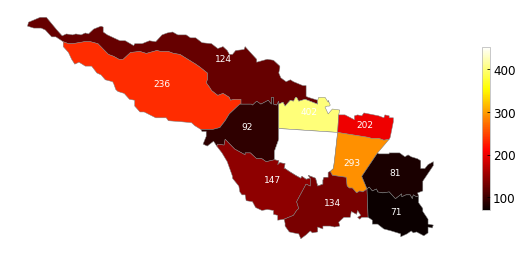

In [ ]:
result = pd.DataFrame()
result["District"] = list(Y_train.columns)
result["District"] = result["District"].apply(lambda x: x.title())
result["District"] = result["District"].apply(lambda x: x.replace("San Francisco De Dos Rios","San Francisco"))
result["Yearly"] = sum(preds)
result["Yearly"] = result["Yearly"].apply(int)
result = result[~result["District"].isin(["Desconocido","Average","Total"])]
print(result.sort_values(by="Yearly"))
san_jose_plotted(san_jose_og, result, "Yearly")

As we can see, the distribution still holds but with lower values in the overall count!

#### Explainability
Explainability of the models is important so we can understand how and why the model has made certain predictions. For this, we can obtain SHAP values. It is more than interesting in this case as we can see which features of which stop helped for the prediction.



In [ ]:
prediction = reg.predict(X_test)

for i in range(50, 55):
    data_for_prediction = X_test.iloc[[i]]  
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(data_for_prediction.values)
    shap.initjs()
    plt = shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)
    display(plt)

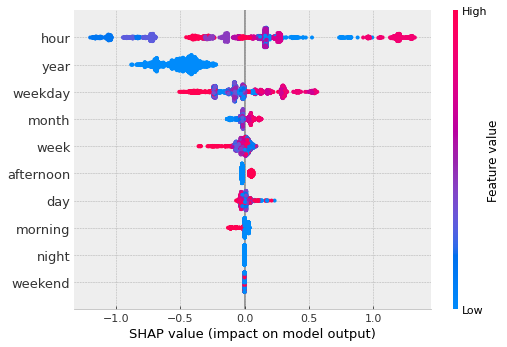

None

In [ ]:
explainer = shap.TreeExplainer(reg)    
shap_values = explainer.shap_values(X_test.values)
plt = shap.summary_plot(shap_values, X_test)
display(plt)

Here ends our notebook, hope you enjoyed it :)

## 🖼️ Visualisations

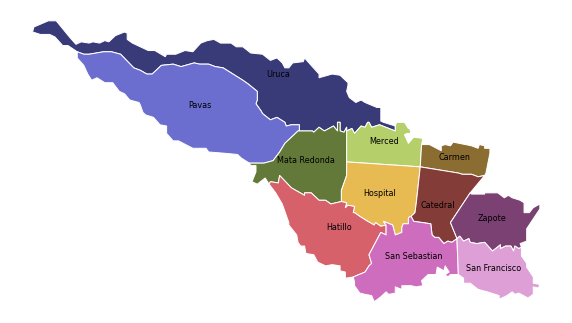

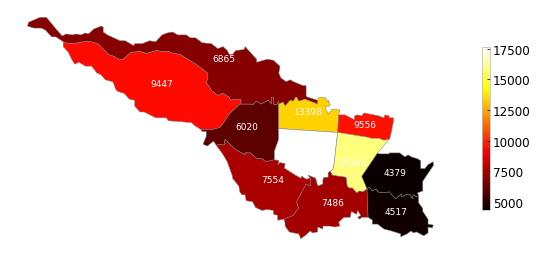

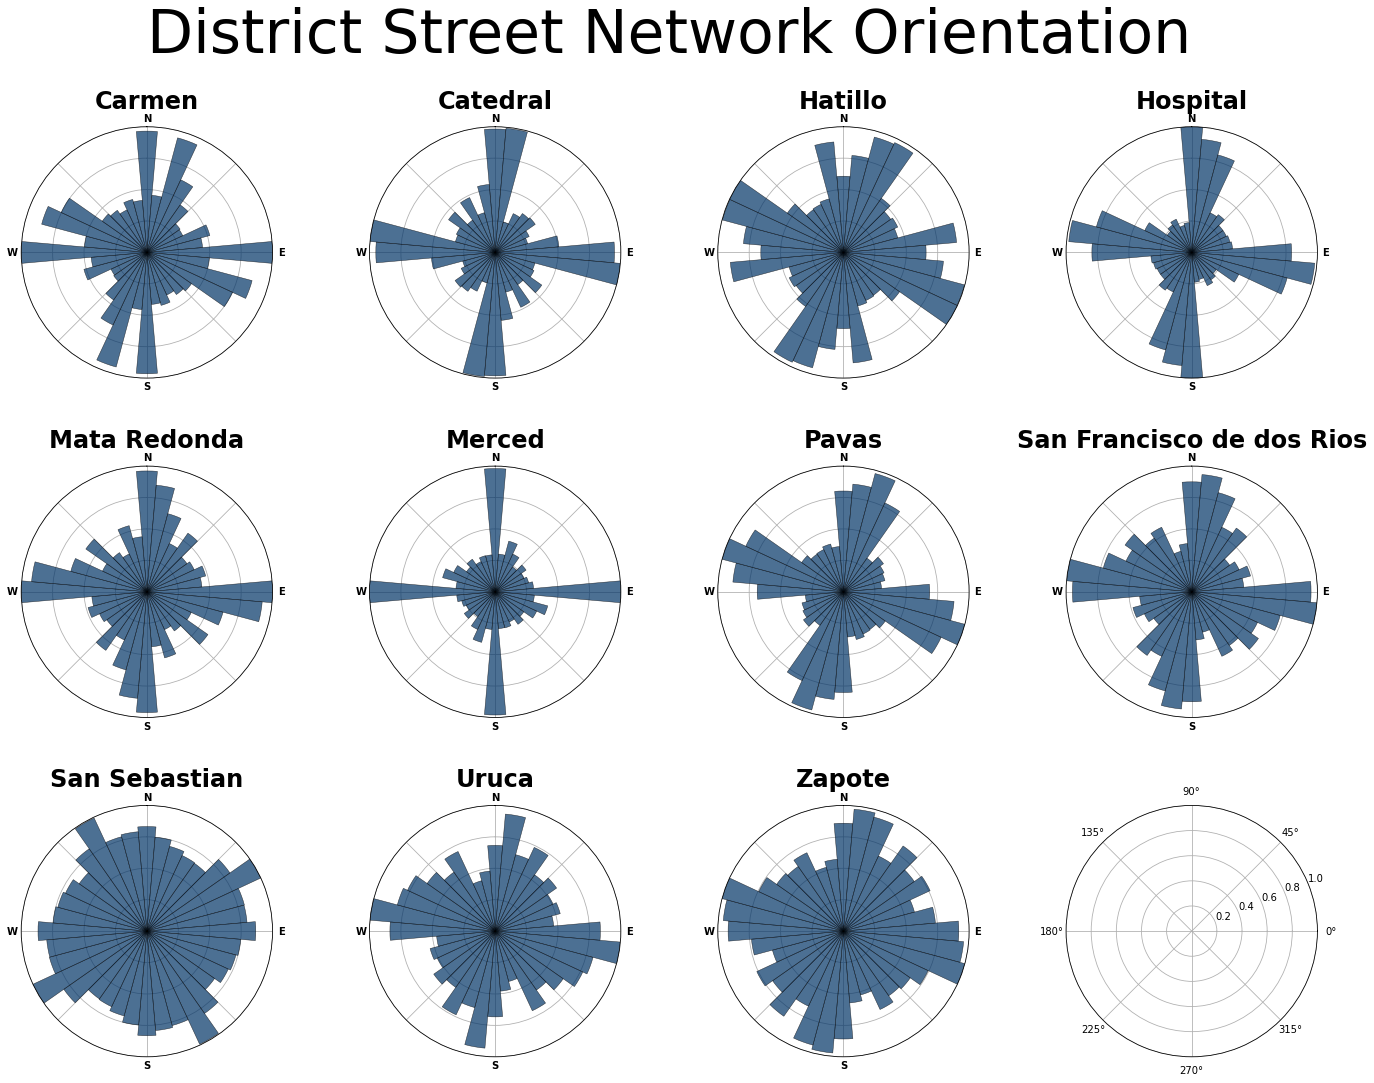

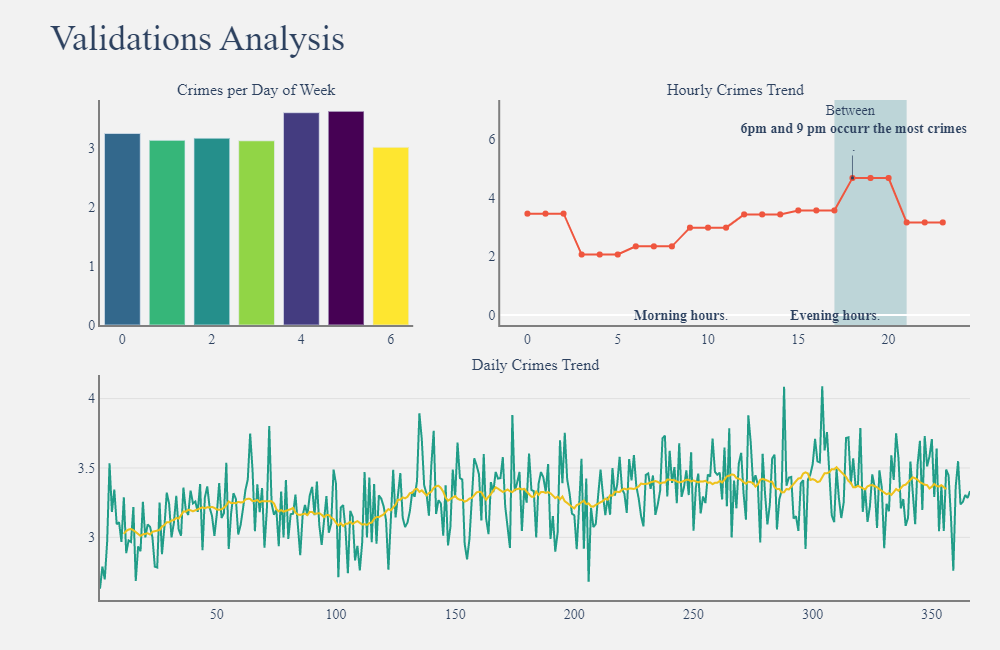

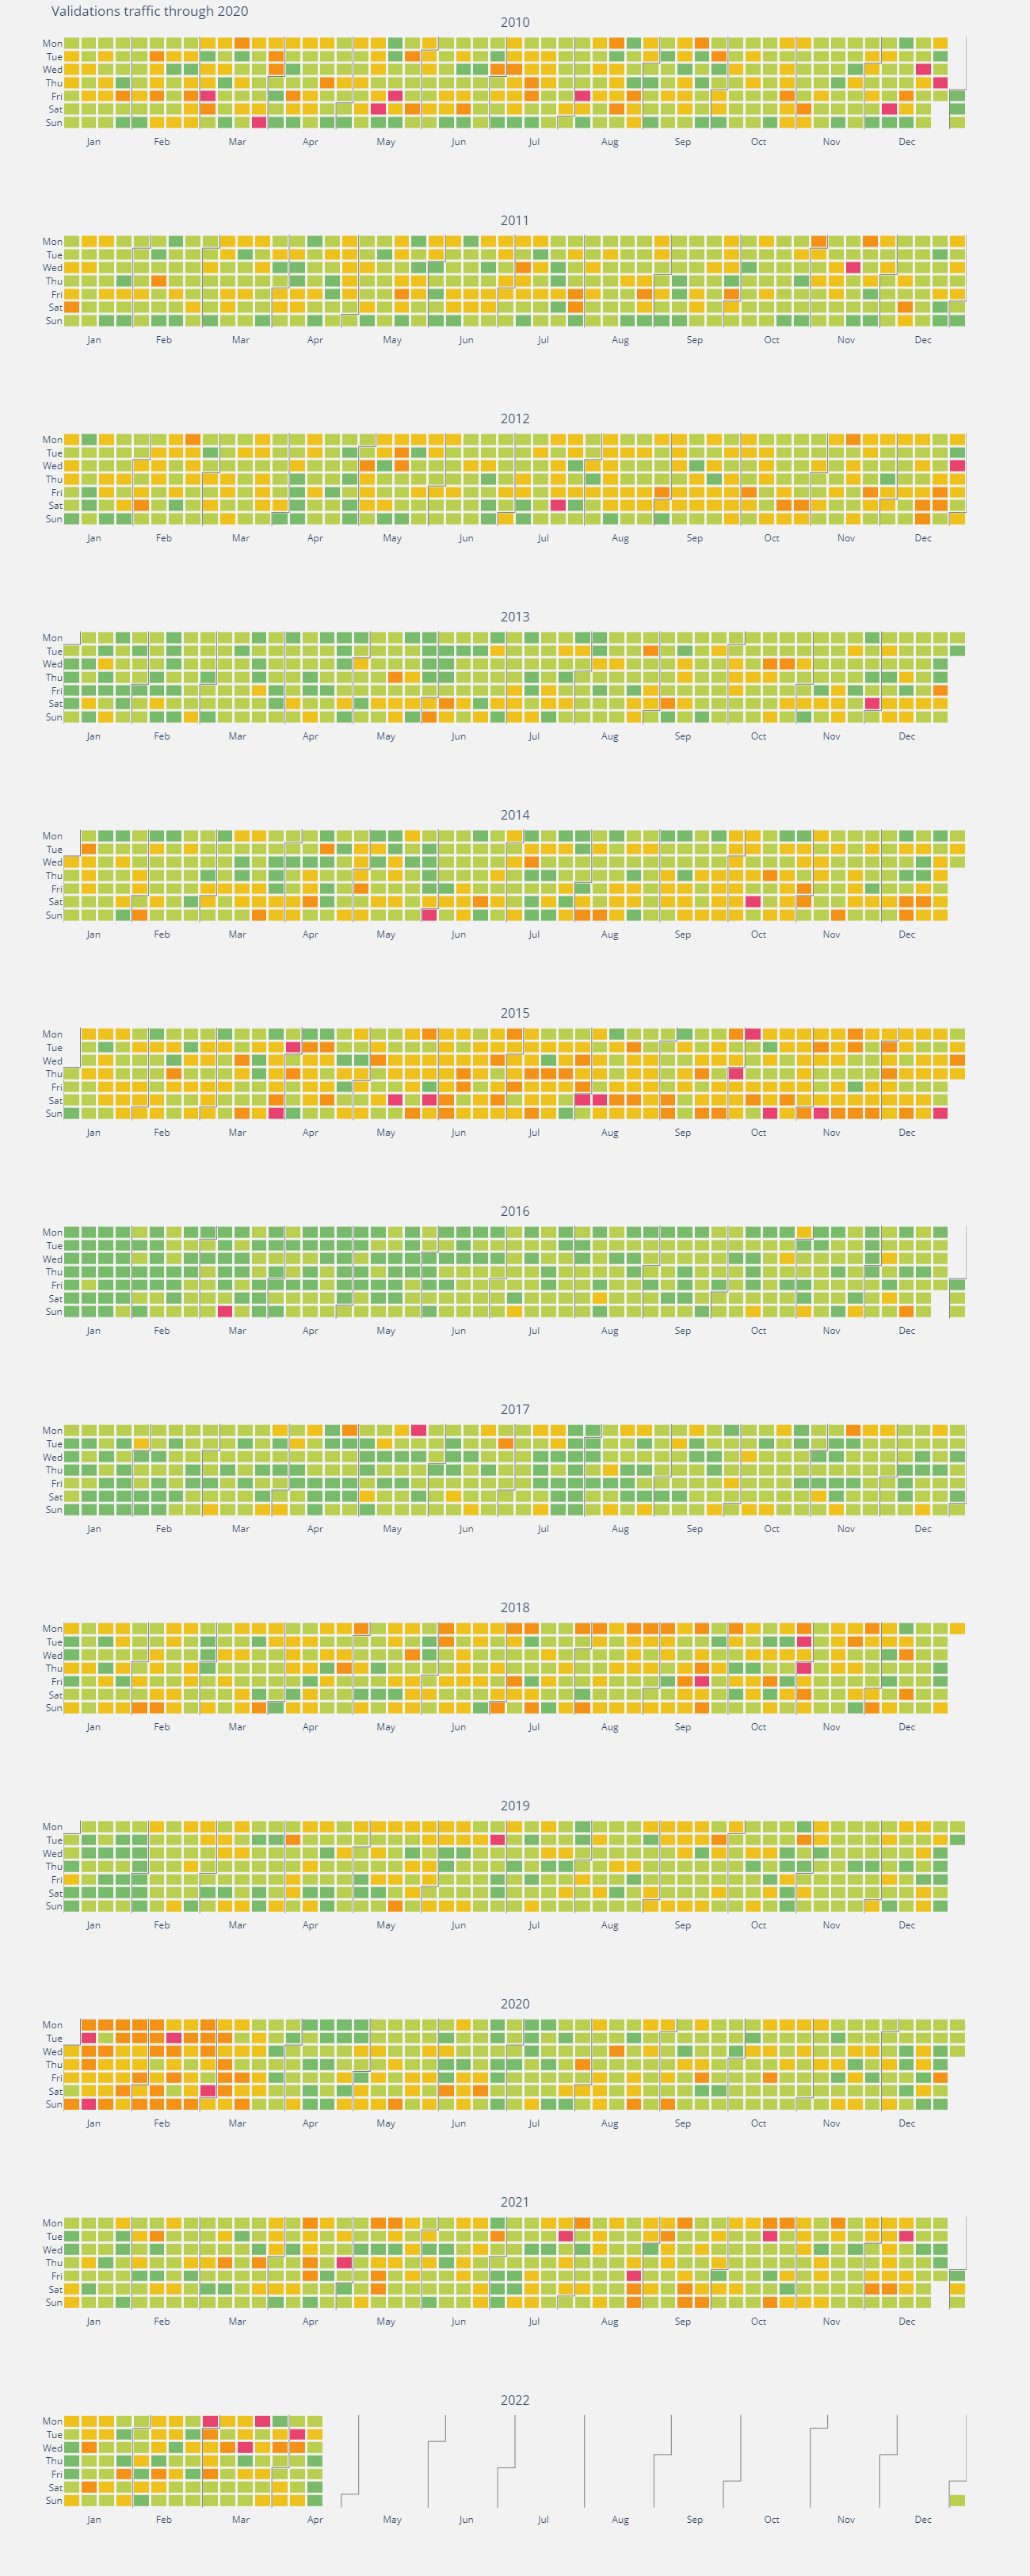

## 👓 References 
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials. 
 
Dataset 
* https://wdl-data.fra1.digitaloceanspaces.com/urbanalytica/urbanalytica_datasets.zip
 
Paper 
* https://www.unwomen.org/en/digital-library/publications/2017/10/safe-cities-and-safe-public-spaces-global-results-report
* https://link.springer.com/article/10.1007/s10940-016-9306-9
* https://www.jstor.org/stable/26329867
* https://link.springer.com/article/10.1007/s10940-020-09490-6
* https://www.sciencedirect.com/science/article/pii/S0198971516304240
* https://crimesciencejournal.biomedcentral.com/articles/10.1186/s40163-020-00125-6#Fig5
* https://link.springer.com/article/10.1007/s10940-016-9306-9
 
Resource 
* https://osmnx.readthedocs.io/en/stable/
* https://dash.plotly.com/
* https://atlas-servicios-ecosistemicos-gam.github.io/
* https://www.inec.cr/

## ⏭️ Appendix


Some of the tests we performed are just placed here.

#### Dickey-Fuller test and correlations

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=8760).mean()
        rolstd = y.rolling(window=8760).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')

##### District: Hospital

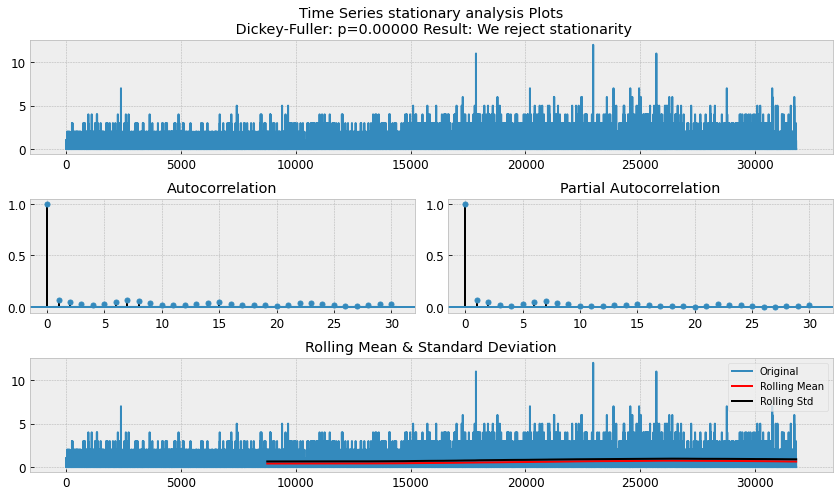

In [ ]:
tsplot(pivot['HOSPITAL'], lags=30)

##### District: Catedral

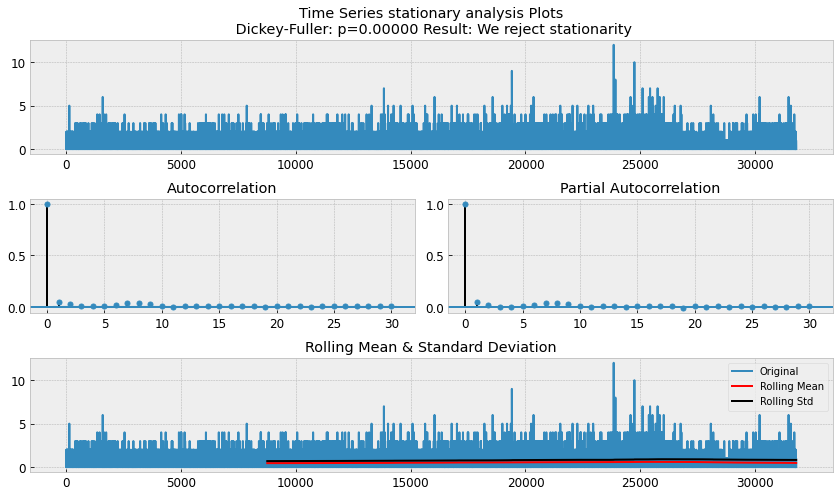

In [ ]:
tsplot(pivot['CATEDRAL'], lags=30)

#### Permutation Importance

In [ ]:
train_df = pivot[(pivot["Date"].dt.year > 2010) & (pivot["Date"].dt.month < 2021)]
test_df = pivot[pivot["Date"].dt.year == 2021]

add_datetime_features(train_df)
add_datetime_features(test_df)

We also tested some statistical features, but they were not as useful.

In [ ]:
# Statistical features

def add_stats_features(df):
  targets = ['Total']
  for t in targets:
    medians = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].median().astype(int)).reset_index()
    medians = medians.rename(columns={t:f'{t}_median'})
    df = df.merge(medians, on=['weekday', 'hour'], how='left')

    stds = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].std()).reset_index()
    stds = stds.rename(columns={t:f'{t}_std'})
    df = df.merge(stds, on=['weekday', 'hour'], how='left')

    mins = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].min().astype(int)).reset_index()
    mins = mins.rename(columns={t:f'{t}_min'})
    df = df.merge(mins, on=['weekday', 'hour'], how='left')

    maxs = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].max().astype(int)).reset_index()
    maxs = maxs.rename(columns={t:f'{t}_max'})
    df = df.merge(maxs, on=['weekday', 'hour'], how='left')

    df_mornings = df[(df.hour >= 6) & (df.hour < 12)]
    morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day'])[t].median().astype(int)).reset_index()
    morning_avgs = morning_avgs.rename(columns={t:f'{t}_morning_avg'})
    df = df.merge(morning_avgs, on=['month', 'day'], how='left')

    quantile25 = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].quantile([.25]).astype(int)).reset_index()
    quantile25 = quantile25.rename(columns={t:f'{t}_quantile25'}).drop(['level_2'], axis=1)
    df = df.merge(quantile25, on=['weekday', 'hour'], how='left')

    quantile75 = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].quantile([.75]).astype(int)).reset_index()
    quantile75 = quantile75.rename(columns={t:f'{t}_quantile75'}).drop(['level_2'], axis=1)
    df = df.merge(quantile75, on=['weekday', 'hour'], how='left')

add_stats_features(train_df)
add_stats_features(test_df)

In [ ]:
targets = ['Total']

X_train = train_df.copy()
X_train = X_train.drop(['Date'], axis=1)
Y_train = X_train['Total']
X_train = X_train.drop(targets, axis=1)

X_test = test_df.copy()
X_test = X_test.drop(['Date'], axis=1)
Y_test = X_test['Total']
X_test = X_test.drop(targets, axis=1)

In [ ]:
from catboost import CatBoostRegressor
import eli5
from eli5.sklearn import PermutationImportance

model = CatBoostRegressor(logging_level='Silent', random_state=42, eval_metric='MAE', loss_function='MAE').fit(X_train.values, Y_train.values)
perm = PermutationImportance(model, random_state=1).fit(X_test, Y_test)
display(eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None))

#### PCA

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(2, 1)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Stop", title="% Explained Variance", ylim=(0.0, 0.2)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Stop", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    # Set up figure
    fig.set(figwidth=width, dpi=100)
    return axs

In [ ]:
X = train_df.copy()
X_t = test_df.copy()

features = train_df.columns.difference(['Date','Total'])
y = X.pop('Total')
X = X.loc[:, features]
X_t = X_t.loc[:, features]
X = X.fillna(0)
X_t = X_t.fillna(0)

from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

X_pca.head(3)

PC1        PC2        PC3       PC4       PC5       PC6       PC7  \
0  23.265498 -15.744109  10.696628 -4.876831  2.063315  0.033738 -2.300799   
1  23.265620 -15.730029   7.720904 -4.855456  2.107502  0.081493 -3.215996   
2  23.272687 -15.696945  -1.279511 -4.803381  2.087120 -0.324454 -1.839540   

         PC8       PC9      PC10  ...      PC14      PC15      PC16      PC17  \
0  11.007095  0.939334  2.496379  ... -0.081254 -0.673178 -0.223744 -0.320508   
1  10.970725  0.192119 -0.209621  ... -0.054781  0.071607 -0.041414 -0.113578   
2  11.178673  0.126417 -0.403131  ... -0.182199  0.071875 -0.601935 -0.119410   

       PC18      PC19      PC20      PC21          PC22          PC23  
0 -0.031412 -0.217902  0.386911 -0.082638  1.208060e-14 -3.643390e-17  
1  0.046393 -0.407259  0.322604 -0.064397  5.914142e-15 -3.387022e-17  
2  0.032802  0.284672  0.360063 -0.052951 -7.696589e-15 -4.356490e-17  

[3 rows x 23 columns]

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings.head(6)

PC1       PC2       PC3       PC4       PC5       PC6  \
District                                                                  
Average      0.001026 -0.000126 -0.008797  0.008527  0.006098  0.282952   
CARMEN       0.000604 -0.000494 -0.002121  0.008686  0.008748  0.144409   
CATEDRAL     0.001258 -0.000269 -0.000727  0.001223  0.019558  0.477421   
DESCONOCIDO  0.000138 -0.000100  0.001730  0.000632  0.001618  0.012603   
HATILLO      0.000364 -0.000710 -0.005679  0.000269 -0.006509  0.032453   
HOSPITAL     0.001241  0.000503 -0.010648  0.031104  0.032778  0.787581   

                  PC7       PC8       PC9      PC10  ...      PC14      PC15  \
District                                             ...                       
Average      0.083511  0.019701  0.148733  0.189777  ...  0.069419  0.021992   
CARMEN       0.102619 -0.005719  0.106896  0.251171  ... -0.072891 -0.027923   
CATEDRAL     0.795748  0.178147 -0.196731 -0.133950  ... -0.021094 -0.009208   
DESCONOCIDO  0.004080  0.000089  0.008774  0.002174  ...  0.001648  0.008092   
HATILLO      0.026129  0.004782  0.035767  0.109343  ...  0.754858 -0.528775   
HOSPITAL    -0.562759 -0.026741 -0.162905 -0.078016  ... -0.009585 -0.017084   

                 PC16      PC17      PC18      PC19      PC20      PC21  \
District                                                                  
Average      0.041086  0.108626  0.038800  0.043425  0.010396  0.112321   
CARMEN       0.058670 -0.070010 -0.037020  0.013113  0.005227 -0.021842   
CATEDRAL     0.031268 -0.049642 -0.015453  0.014368 -0.004516 -0.022945   
DESCONOCIDO -0.019666  0.022528  0.013651 -0.008744  0.024572  0.989674   
HATILLO     -0.122540 -0.050184 -0.025600  0.038735  0.005439 -0.018091   
HOSPITAL     0.045179 -0.026651 -0.011424 -0.012391 -0.015699 -0.022356   

                 PC22      PC23  
District                         
Average      0.882495  0.002204  
CARMEN      -0.135768 -0.000339  
CATEDRAL    -0.135768 -0.000339  
DESCONOCIDO -0.135768 -0.000339  
HATILLO     -0.135768 -0.000339  
HOSPITAL    -0.135768 -0.000339  

[6 rows x 23 columns]

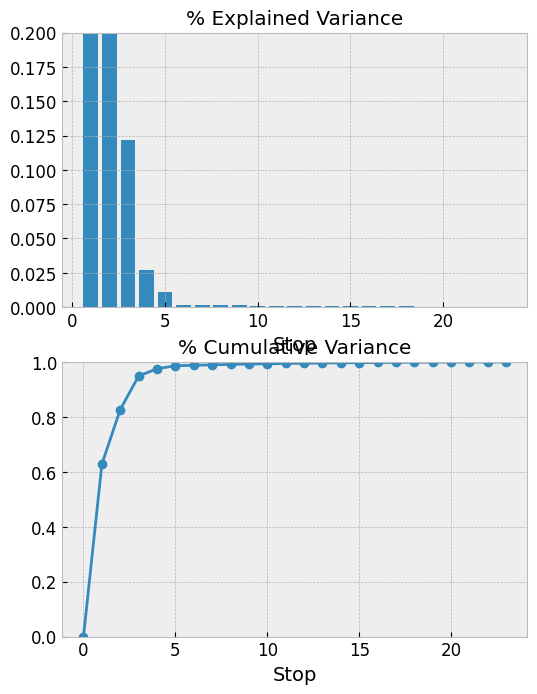

In [ ]:
plot_variance(pca, width=6);

In [ ]:
df_train = pd.concat([X_train, X_pca], axis=1)
df_test = pd.concat([X_test, X_t_pca], axis=1)

In [ ]:
from catboost import CatBoostRegressor
import eli5
from eli5.sklearn import PermutationImportance

model = CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE').fit(X_train.values, Y_train.values)
perm = PermutationImportance(model, random_state=1).fit(X_test, Y_test)
display(eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None))